# Importar Librerias necesarias

In [191]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_absolute_error
from pmdarima.arima import auto_arima
from pmdarima.arima import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from fbprophet import Prophet
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import pickle
from sklearn.ensemble import RandomForestRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import Callback

# Cargando los Datos

In [192]:
humedad = pd.read_csv('humedad_suelo_1.csv')

salinidad = pd.read_csv('salinidad_suelo_1.csv')

temperatura = pd.read_csv('temperatura_suelo_1.csv')

ambiente = pd.read_csv('temperatura_humedad_1.csv')

In [193]:
humedad.head()

Fecha    H10    H20    H30    H40    H50    H60    H70    H80
0  2021-07-01 00:08:29  36.77  43.88  49.75  43.21  42.59  44.20  41.89  45.43
1  2021-07-01 00:18:46  36.75  43.86  49.73  43.24  42.57  44.21  41.89  45.44
2  2021-07-01 00:29:03  36.71  43.79  49.74  43.20  42.56  44.22  41.90  45.43
3  2021-07-01 00:39:20  36.70  43.84  49.77  43.21  42.53  44.21  41.90  45.41
4  2021-07-01 00:49:37  36.66  43.78  49.75  43.21  42.51  44.20  41.83  45.43

Tenemos datos de humedad en (definir unidades) para profundidades de 10 a 80 cm.


In [194]:
salinidad.head(10)

Fecha    S10    S20    S30    S40    S50    S60    S70    S80
0  2021-07-01 00:08:29  0.580  0.874  0.903  0.756  0.912  1.221  0.941  1.042
1  2021-07-01 00:18:46  0.579  0.873  0.904  0.755  0.909  1.222  0.942  1.046
2  2021-07-01 00:29:03  0.579  0.872  0.902  0.757  0.910  1.221  0.941  1.044
3  2021-07-01 00:39:20  0.580  0.872  0.903  0.755  0.910  1.221  0.942  1.044
4  2021-07-01 00:49:37  0.578  0.872  0.903  0.755  0.909  1.221  0.942  1.043
5  2021-07-01 00:59:54  0.577  0.872  0.899  0.755  0.909  1.221  0.939  1.044
6  2021-07-01 01:10:11  0.577  0.868  0.899  0.755  0.912  1.221  0.940  1.044
7  2021-07-01 01:20:28  0.573  0.863  0.897  0.755  0.911  1.222  0.942  1.042
8  2021-07-01 01:30:45  0.571  0.863  0.897  0.755  0.909  1.221  0.941  1.045
9  2021-07-01 01:41:02  0.570  0.860  0.896  0.755  0.909  1.221  0.939  1.046

Tenemos datos de salinidad en (definir unidades) para profundidades de 10 a 80 cm 

In [195]:
temperatura.head(10)

Fecha    T10    T20    T30    T40    T50    T60    T70    T80
0  2021-07-01 00:08:29  21.94  22.88  22.73  21.90  22.58  21.89  21.32  20.73
1  2021-07-01 00:18:46  21.84  22.87  22.72  21.90  22.56  21.91  21.34  20.73
2  2021-07-01 00:29:03  21.82  22.83  22.69  21.90  22.58  21.92  21.33  20.74
3  2021-07-01 00:39:20  21.72  22.75  22.65  21.92  22.62  21.93  21.36  20.73
4  2021-07-01 00:49:37  21.71  22.75  22.61  21.88  22.60  21.93  21.35  20.74
5  2021-07-01 00:59:54  21.64  22.63  22.61  21.90  22.60  21.95  21.36  20.74
6  2021-07-01 01:10:11  21.63  22.63  22.61  21.89  22.62  21.94  21.35  20.73
7  2021-07-01 01:20:28  21.61  22.63  22.61  21.89  22.64  21.95  21.35  20.73
8  2021-07-01 01:30:45  21.60  22.54  22.56  21.87  22.65  21.96  21.36  20.74
9  2021-07-01 01:41:02  21.59  22.51  22.52  21.86  22.65  21.96  21.36  20.73

Tenemos datos de temperatura en (definir unidades) para profundidades de 10 a 80 cm 

In [196]:
ambiente

Fecha  Temperatura  Humedad
0      2021-06-30 00:00:15       22.940   89.664
1      2021-06-30 00:15:14       22.786   90.155
2      2021-06-30 00:30:14       22.356   91.261
3      2021-06-30 00:45:14       22.510   84.902
4      2021-06-30 01:00:14       22.632   82.107
...                    ...          ...      ...
17738  2021-12-31 22:45:14        7.212   99.032
17739  2021-12-31 23:00:14        7.028   98.879
17740  2021-12-31 23:15:14        6.352   97.927
17741  2021-12-31 23:30:14        6.107   99.002
17742  2021-12-31 23:45:14        5.922   99.309

[17743 rows x 3 columns]

Tambien tenemos los valores de de temperatura y humedad medidos cada 15 minutos durante 6 meses

# INSPECCIÓN DE LOS DATOS

Sabemos que los dataframes contienen valores de Salinidad, Temperatura y humedad del suelo. ¿Cuales son sus valores maximos y minimos a cada profunidad?

In [197]:

Humedad_Rango = pd.DataFrame({'Profundidad':humedad.columns[1:], 'Valores Minimos':humedad.min().values[1:], 'Valores Maximos':humedad.max().values[1:]})

In [198]:
Humedad_Rango

Profundidad Valores Minimos Valores Maximos
0         H10           29.69           58.23
1         H20           38.84           55.53
2         H30           45.62            58.0
3         H40           41.57           49.54
4         H50           41.39           47.54
5         H60           43.46            48.4
6         H70           41.53           46.39
7         H80           45.17           52.04

Hacemos lo mismo con los valores de salinidad y temperatura del suelo:

In [199]:
Salinidad_Rango = pd.DataFrame({'Profundidad':salinidad.columns[1:], 'Valores Minimos':salinidad.min().values[1:], 'Valores Maximos':salinidad.max().values[1:]})

Temperatura_Rango = pd.DataFrame({'Profundidad':temperatura.columns[1:], 'Valores Minimos':temperatura.min().values[1:], 'Valores Maximos':temperatura.max().values[1:]})


In [200]:
Salinidad_Rango

Profundidad Valores Minimos Valores Maximos
0         S10           0.229           1.173
1         S20           0.372           1.272
2         S30           0.403           1.043
3         S40           0.313           0.828
4         S50           0.416           1.069
5         S60           0.653           1.464
6         S70           0.521           1.144
7         S80           0.596           1.238

In [201]:
Temperatura_Rango

Profundidad Valores Minimos Valores Maximos
0         T10            3.38           35.09
1         T20            5.37           27.95
2         T30            7.01           25.33
3         T40            7.71           23.83
4         T50             9.9           24.44
5         T60           10.49           23.97
6         T70           10.76            23.5
7         T80           10.87           23.04

Observemos ahora la cantidad de los datos y si existen datos nulos.

In [202]:
salinidad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25050 entries, 0 to 25049
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Fecha   25050 non-null  object 
 1   S10     25050 non-null  float64
 2   S20     25050 non-null  float64
 3   S30     25050 non-null  float64
 4   S40     25050 non-null  float64
 5   S50     25049 non-null  float64
 6   S60     25049 non-null  float64
 7   S70     25049 non-null  float64
 8   S80     25049 non-null  float64
dtypes: float64(8), object(1)
memory usage: 1.7+ MB


Los valores de salinidad tienen 25050 entradas de las cuales solamente hay 1 valor nulo para las profundidades a partir de 50 cm.

In [203]:
humedad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25050 entries, 0 to 25049
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Fecha   25050 non-null  object 
 1   H10     25050 non-null  float64
 2   H20     25050 non-null  float64
 3   H30     25050 non-null  float64
 4   H40     25050 non-null  float64
 5   H50     25049 non-null  float64
 6   H60     25049 non-null  float64
 7   H70     25049 non-null  float64
 8   H80     25049 non-null  float64
dtypes: float64(8), object(1)
memory usage: 1.7+ MB


In [204]:
temperatura.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25050 entries, 0 to 25049
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Fecha   25050 non-null  object 
 1   T10     25050 non-null  float64
 2   T20     25050 non-null  float64
 3   T30     25050 non-null  float64
 4   T40     25050 non-null  float64
 5   T50     25049 non-null  float64
 6   T60     25049 non-null  float64
 7   T70     25049 non-null  float64
 8   T80     25049 non-null  float64
dtypes: float64(8), object(1)
memory usage: 1.7+ MB


Hacemos lo mismo para los valores de temperatura y humedad. Observamos exactamente lo mismo 25050 entradas y 1 valor nulo en las profundidades de 50 a 80 cm.

In [205]:
print(salinidad[salinidad['S60'].isnull()].index)
print(humedad[humedad['H60'].isnull()].index)
print(temperatura[temperatura['T60'].isnull()].index)

Int64Index([15472], dtype='int64')
Int64Index([15472], dtype='int64')
Int64Index([15472], dtype='int64')


In [206]:
salinidad = salinidad.dropna(axis=0)
temperatura = temperatura.dropna(axis=0)
humedad = humedad.dropna(axis=0)

In [207]:
ambiente.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17743 entries, 0 to 17742
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Fecha        17743 non-null  object 
 1   Temperatura  17743 non-null  float64
 2   Humedad      17743 non-null  float64
dtypes: float64(2), object(1)
memory usage: 416.0+ KB


En el caso de los valores de temperatura y humedad ambientales, observamos:
- Que no hay la misma cantidad de datos
- Y que en este caso no hay valores Nulos

Vamos a observar las fechas:

In [208]:
salinidad.Fecha

0        2021-07-01 00:08:29
1        2021-07-01 00:18:46
2        2021-07-01 00:29:03
3        2021-07-01 00:39:20
4        2021-07-01 00:49:37
                ...         
25045    2021-12-31 23:09:30
25046    2021-12-31 23:19:47
25047    2021-12-31 23:30:04
25048    2021-12-31 23:40:21
25049    2021-12-31 23:50:38
Name: Fecha, Length: 25049, dtype: object

Está en formato object, deberíamos pasarla a formato Datetime. Lo haremos para todos los dataframes

In [209]:
salinidad['Fecha'] = pd.to_datetime(salinidad.Fecha)

humedad['Fecha'] = pd.to_datetime(humedad.Fecha)

temperatura['Fecha'] = pd.to_datetime(temperatura.Fecha)

ambiente['Fecha'] = pd.to_datetime(ambiente.Fecha)

Para poder hacer análisis temporales, vamos a pasar la fecha como indice

In [210]:
salinidad = salinidad.set_index('Fecha')

humedad = humedad.set_index('Fecha')

temperatura = temperatura.set_index('Fecha')

ambiente = ambiente.set_index('Fecha')

Ahora vamos a ver algunos valores estadísticos de cada dataframe

In [211]:
salinidad.describe()

S10           S20           S30           S40           S50  \
count  25049.000000  25049.000000  25049.000000  25049.000000  25049.000000   
mean       0.580557      0.755954      0.724123      0.553060      0.701296   
std        0.170488      0.203845      0.173122      0.138511      0.168261   
min        0.229000      0.372000      0.403000      0.313000      0.416000   
25%        0.432000      0.543000      0.542000      0.412000      0.531000   
50%        0.603000      0.821000      0.792000      0.602000      0.750000   
75%        0.710000      0.923000      0.862000      0.669000      0.829000   
max        1.173000      1.272000      1.043000      0.828000      1.069000   

                S60           S70           S80  
count  25049.000000  25049.000000  25049.000000  
mean       1.032621      0.804815      0.915413  
std        0.232388      0.178825      0.195828  
min        0.653000      0.521000      0.596000  
25%        0.798000      0.632000      0.726000  
50%        1.096000      0.842000      0.953000  
75%        1.219000      0.946000      1.090000  
max        1.464000      1.144000      1.238000

Datos interesantes que se pueden observar aquí son:

- A 60 cm la media de la salinidad aumenta bastante y encontramos los valores maximos y minimos mas altos de todo el Dataframe
- Generalmente la salinidad aumenta con la profundidad
- La media y la mediana se encuentran bastante cerca, parece que los valores están distribuidos de una forma normal

In [212]:
humedad.describe()

H10           H20           H30           H40           H50  \
count  25049.000000  25049.000000  25049.000000  25049.000000  25049.000000   
mean      46.137366     46.145686     50.826819     44.395160     43.417457   
std        6.150313      2.383591      1.998459      1.286509      1.030991   
min       29.690000     38.840000     45.620000     41.570000     41.390000   
25%       42.250000     44.860000     49.940000     43.640000     42.810000   
50%       47.600000     46.220000     51.040000     44.600000     43.430000   
75%       50.380000     47.300000     51.960000     45.080000     43.860000   
max       58.230000     55.530000     58.000000     49.540000     47.540000   

                H60           H70           H80  
count  25049.000000  25049.000000  25049.000000  
mean      45.216649     42.721238     46.529593  
std        0.617816      0.590194      0.543591  
min       43.460000     41.530000     45.170000  
25%       44.900000     42.220000     46.270000  
50%       45.310000     42.780000     46.620000  
75%       45.580000     43.030000     46.960000  
max       48.400000     46.390000     52.040000

En el caso de la humedad:
- La media mas baja de humedad se encuentra a 70 cm, curioso ya que solo 10 cm mas abajo la humedad aumenta
- La media de humedad mas baja se encuentra a 30 cm, indicando tal vez una capa geologica que retiene mucho la humedad
- La desviación estandar disminuye con la profundidad, siendo muy alta a 10 cm y muy baja a 80 cm.

In [213]:
temperatura.describe()

T10           T20           T30           T40           T50  \
count  25049.000000  25049.000000  25049.000000  25049.000000  25049.000000   
mean      17.709835     17.586688     17.536787     17.363183     18.796364   
std        6.258084      5.742699      5.438506      5.213346      4.973498   
min        3.380000      5.370000      7.010000      7.710000      9.900000   
25%       12.020000     11.640000     11.740000     11.880000     13.590000   
50%       18.990000     18.900000     19.020000     18.980000     20.480000   
75%       22.520000     22.630000     22.500000     22.170000     23.370000   
max       35.090000     27.950000     25.330000     23.830000     24.440000   

                T60           T70           T80  
count  25049.000000  25049.000000  25049.000000  
mean      18.740175     18.644106     18.419725  
std        4.744369      4.549158      4.358779  
min       10.490000     10.760000     10.870000  
25%       13.920000     14.160000     14.250000  
50%       20.480000     20.420000     20.170000  
75%       23.040000     22.760000     22.280000  
max       23.970000     23.500000     23.040000

Para la temperatura:
- En lineas generales parece que aumenta con la profundidad pero no linealmente. La media maxima de temperatura se encuentra a 60 cm coincidiendo con la mayor concentración de salinidad
- El valor minimo de temperatura aumenta con la profundidad

# Visualización de los Datos

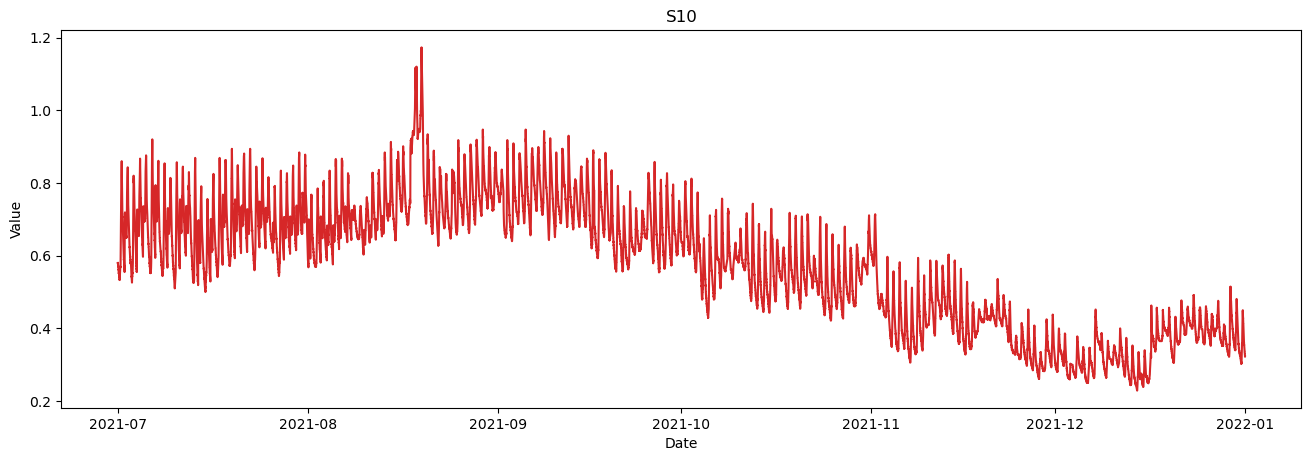

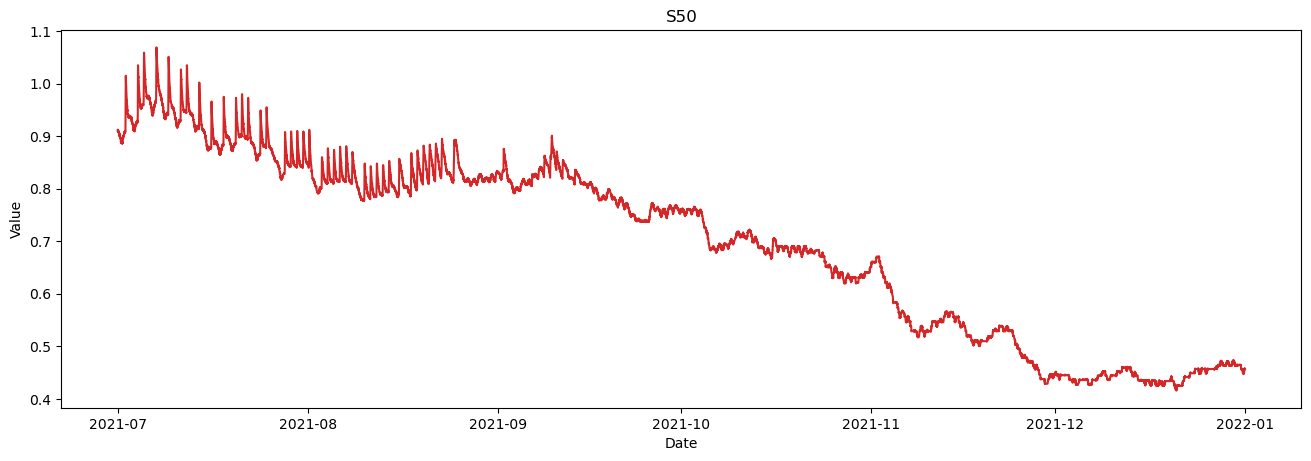

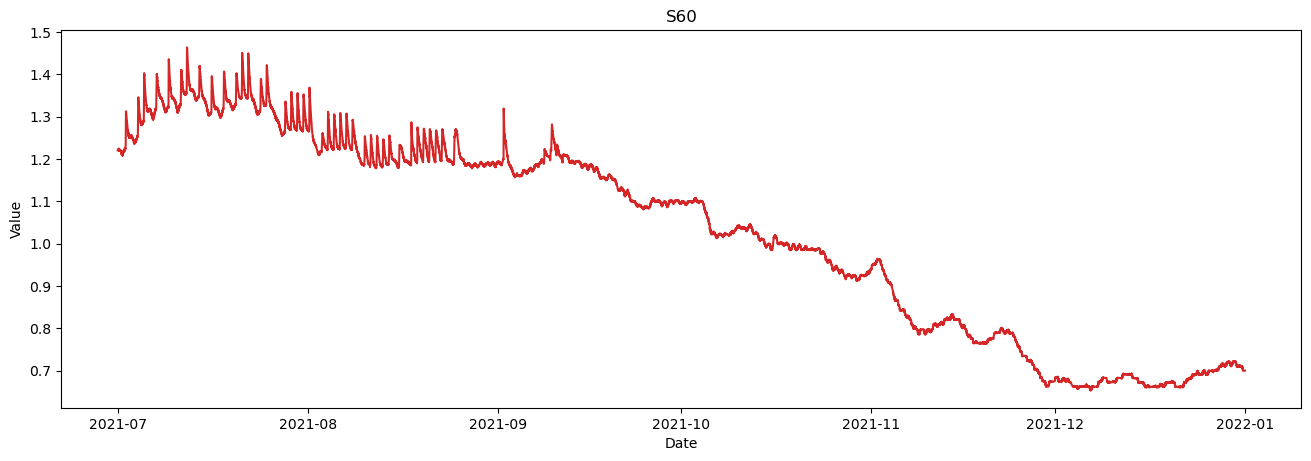

In [214]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

for i in salinidad.columns:
    plot_df(salinidad, salinidad.index, salinidad[i], title=i)

Hacemos lo mismo para las variables de humedad y temperatura

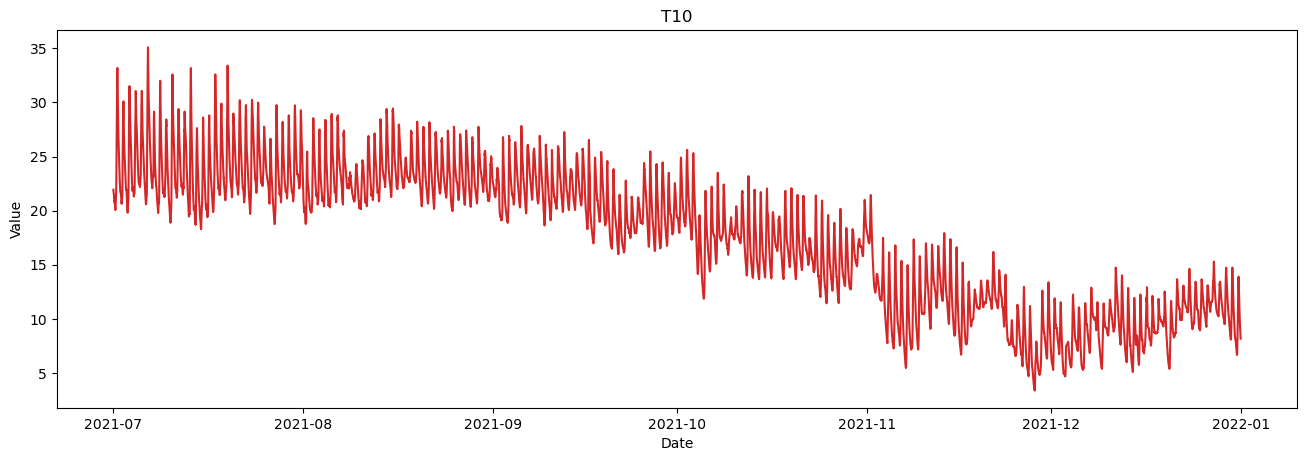

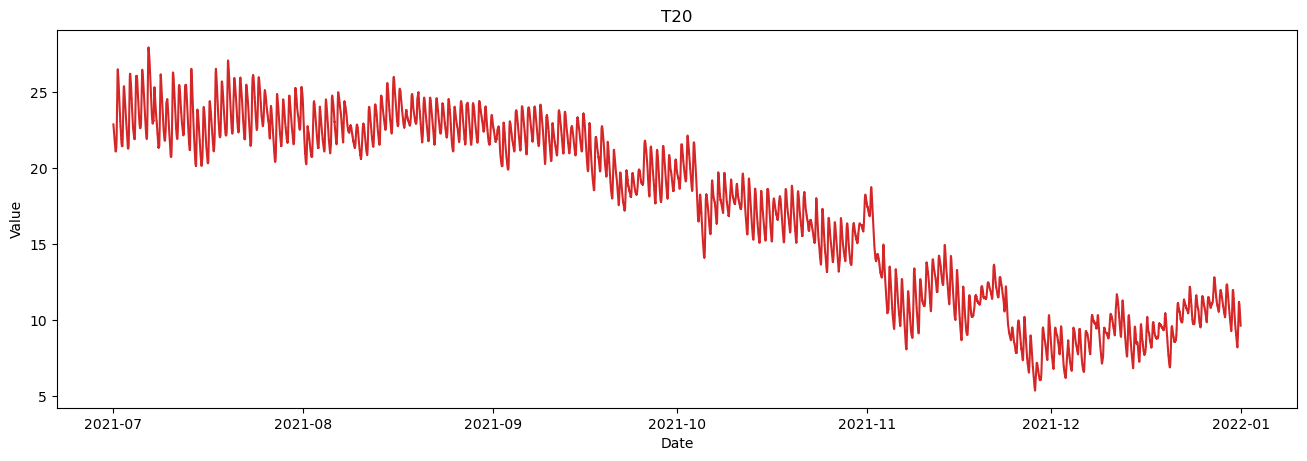

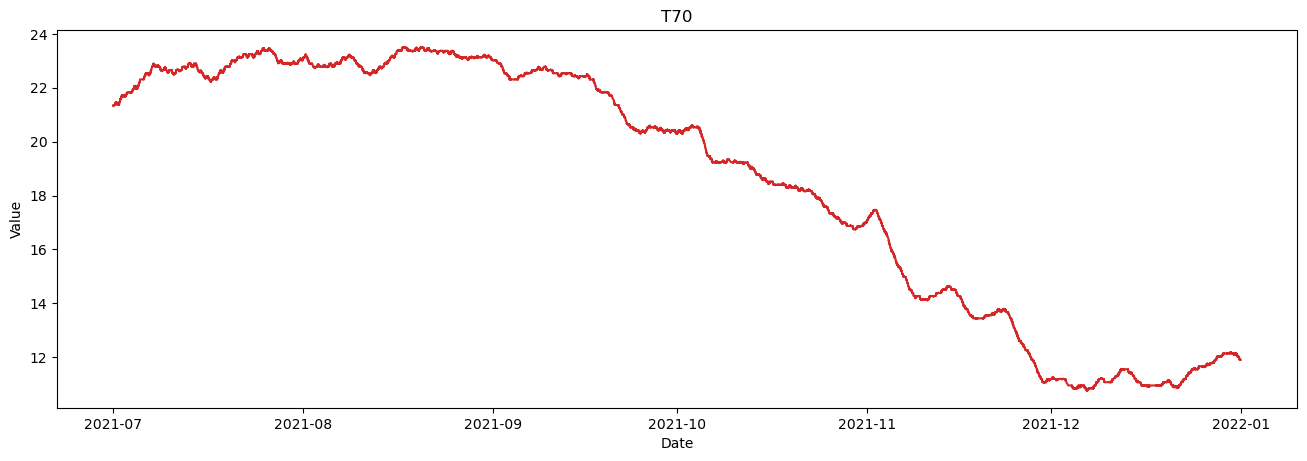

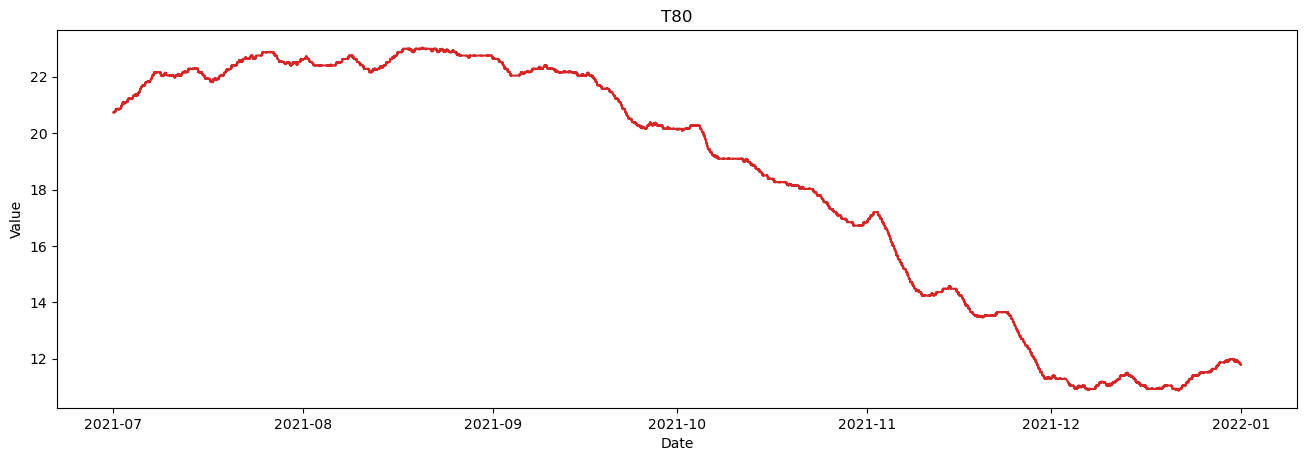

In [215]:
for i in temperatura.columns:
    plot_df(temperatura, temperatura.index, temperatura[i], title=i)

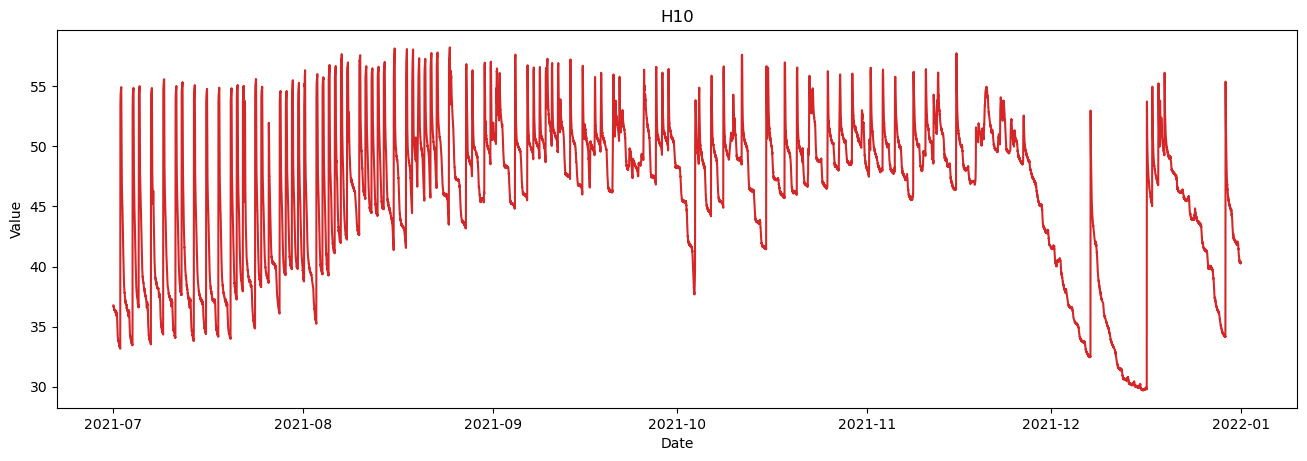

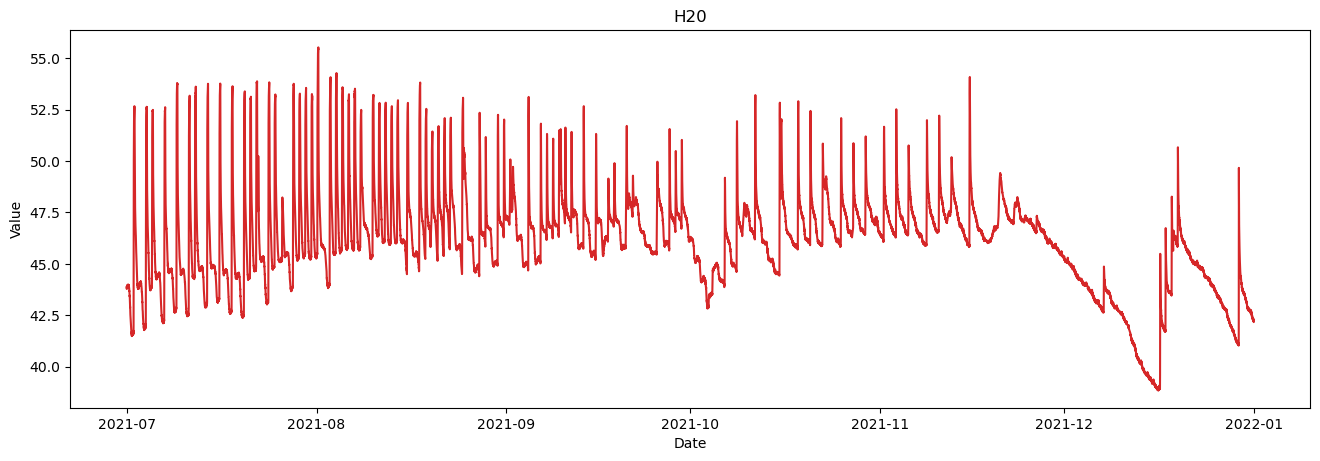

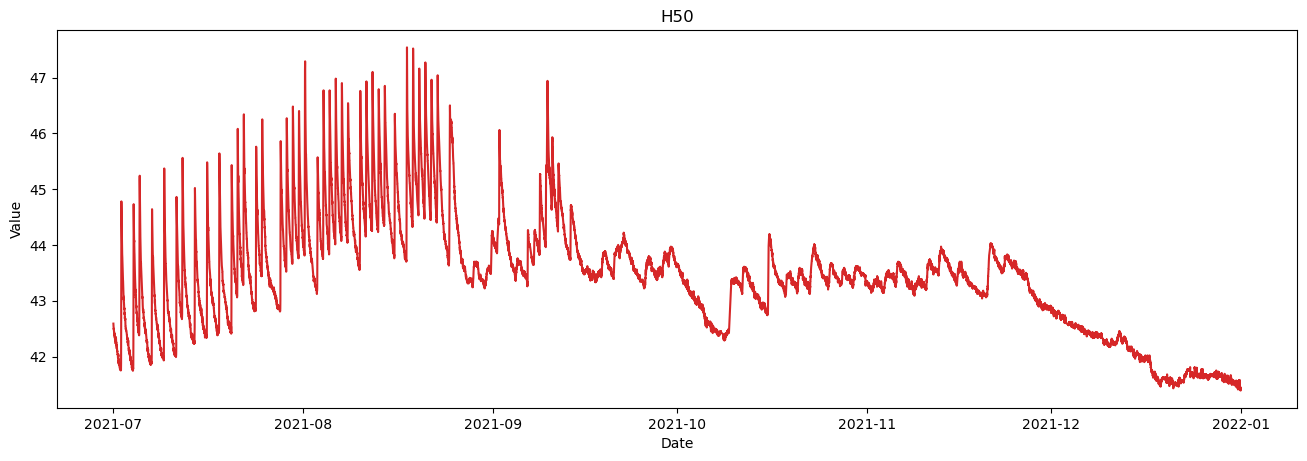

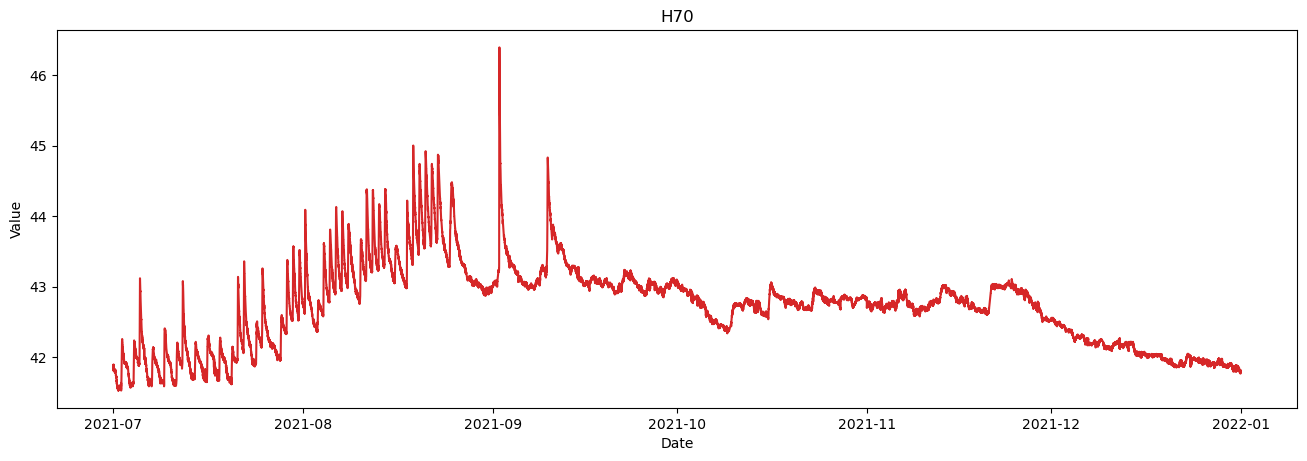

In [216]:
for i in humedad.columns:
    plot_df(humedad, humedad.index, humedad[i], title=i)

La temperatura y la salinidad presentan características comunes. Como por ejemplo que el ruido de la gráfica se atenua con la profundidad y que la tendencía de estos dos parametros disminuye de Junio a Diciembre (lo cual parece lógico). No ocurre lo mismo con la humedad la cual, presenta muchísimo ruido, en esta se aprecia siempre dos minimos de humedad a principios de Octubre y a medidados de Diciembre en todas las profundidades. Además existe un pico máximo en Septiembre que se aprecia mucho desde 60 cm de profundidad.

# PROCESAMIENTO DE LOS DATOS

El objetivo de nuestro proyecto es que el programa de riego decida si regar o no regar en los proximos tres o siete dias atendiendo a los datos de temperatura, salinidad y humedad. Para ello no vamos a necesitar todos los datos que hemos visto hasta ahora. De hecho solo necesitaremos los datos de 20 a 60 cm eliminando los de 10, 70 y 80 cm de profundidad. 
Además con el fin de agilizar los calculos, utilizaremos los valores medios de los valores de temperatura, salinidad y humedad en diferentes profundidades.

In [217]:
#temperatura = temperatura.set_index('Fecha')
#salinidad = salinidad.set_index('Fecha')
#humedad = humedad.set_index('Fecha')

In [218]:
# Primero eliminamos las profundidades de 10, 70 y 80 cm

temperatura = temperatura.drop(['T10', 'T70', 'T80'], axis=1)

salinidad = salinidad.drop(['S10', 'S70', 'S80'], axis=1)

humedad = humedad.drop(['H10', 'H70', 'H80'], axis=1)

In [219]:
# Segundo sacamos la media 

temperatura['T'] = temperatura.mean(axis=1)

salinidad['S'] = salinidad.mean(axis=1)

humedad['H'] = humedad.mean(axis=1)


In [220]:
temp = temperatura.loc[:,'T']

sal = salinidad.loc[:,'S']

hum = humedad.loc[:,'H']

hum

Fecha
2021-07-01 00:08:29    44.726
2021-07-01 00:18:46    44.722
2021-07-01 00:29:03    44.702
2021-07-01 00:39:20    44.712
2021-07-01 00:49:37    44.690
                        ...  
2021-12-31 23:09:30    43.252
2021-12-31 23:19:47    43.268
2021-12-31 23:30:04    43.260
2021-12-31 23:40:21    43.264
2021-12-31 23:50:38    43.270
Name: H, Length: 25049, dtype: float64

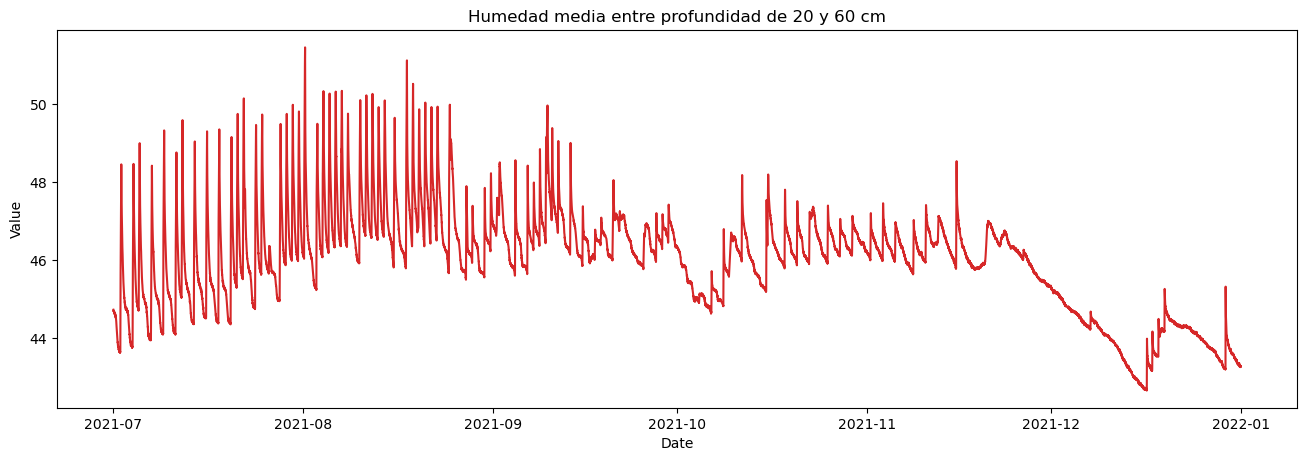

In [221]:
# Proyectamos de nuevo los datos

plot_df(hum, hum.index, hum, title='Humedad media entre profundidad de 20 y 60 cm')

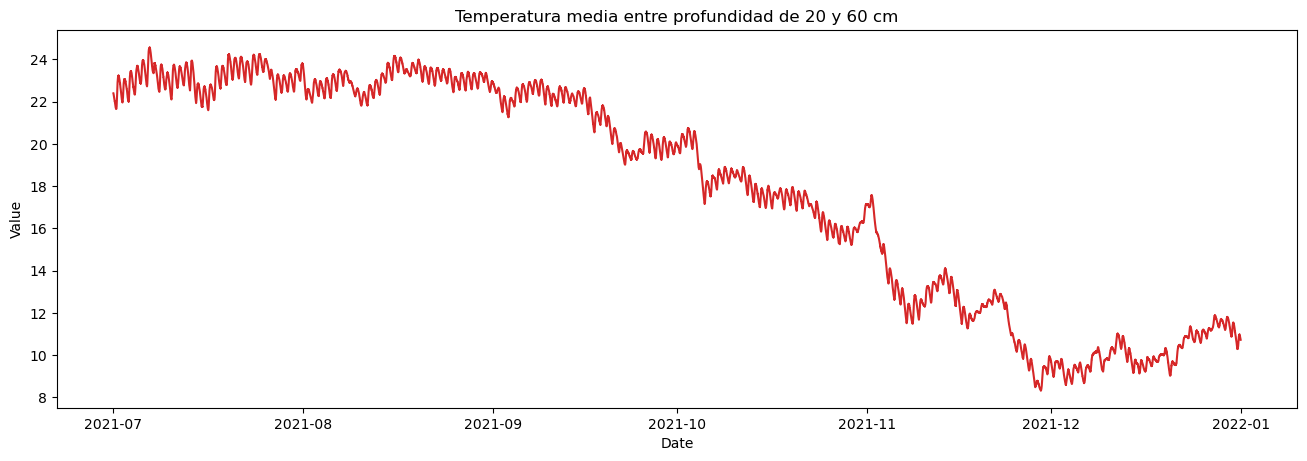

In [222]:

plot_df(temp, temp.index, temp, title='Temperatura media entre profundidad de 20 y 60 cm')

In [223]:

plot_df(sal, sal.index, sal, title='Salinidad media entre profundidad de 20 y 60 cm')

## STACIONALITY

Vamos a descomponer las series temporales que hemos proyectado para conocer la estacionalidad, la tendencia y el ruido de cada gráfica.

In [224]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse


In [225]:
time_gap = pd.DataFrame(data=salinidad.index)

time_gap['difference'] = time_gap.diff()

time_gap['difference'].value_counts()

0 days 00:10:17    23646
0 days 00:12:08      252
0 days 00:12:07      244
0 days 00:12:09      102
0 days 00:12:06       56
                   ...  
0 days 02:26:21        1
0 days 01:44:55        1
0 days 00:41:08        1
0 days 00:12:21        1
0 days 04:21:21        1
Name: difference, Length: 162, dtype: int64

Observamos que los valores que se recogen por parte del sensor no son siempre de 10 minutos 17 segundos, por ello lo primero es dejar los valores de tiempo resampleados a horas.

In [226]:
temperatura_pro = temp.reset_index()

salinidad_pro = sal.reset_index()

humedad_pro = hum.reset_index()

temperatura_pro = temperatura_pro.resample('H', on='Fecha').mean().dropna()
salinidad_pro = salinidad_pro.resample('H', on='Fecha').mean().dropna()
humedad_pro = humedad_pro.resample('H', on='Fecha').mean().dropna()

print(temperatura_pro)

print(salinidad_pro)

print(humedad_pro)

                             T
Fecha                         
2021-07-01 00:00:00  22.373000
2021-07-01 01:00:00  22.316800
2021-07-01 02:00:00  22.243000
2021-07-01 03:00:00  22.172333
2021-07-01 04:00:00  22.085333
...                        ...
2021-12-31 19:00:00  10.974333
2021-12-31 20:00:00  10.937667
2021-12-31 21:00:00  10.888000
2021-12-31 22:00:00  10.830000
2021-12-31 23:00:00  10.760800

[4292 rows x 1 columns]
                            S
Fecha                        
2021-07-01 00:00:00  0.932267
2021-07-01 01:00:00  0.929360
2021-07-01 02:00:00  0.926933
2021-07-01 03:00:00  0.924367
2021-07-01 04:00:00  0.920933
...                       ...
2021-12-31 19:00:00  0.495933
2021-12-31 20:00:00  0.495333
2021-12-31 21:00:00  0.493267
2021-12-31 22:00:00  0.490900
2021-12-31 23:00:00  0.488960

[4292 rows x 1 columns]
                             H
Fecha                         
2021-07-01 00:00:00  44.708000
2021-07-01 01:00:00  44.688400
2021-07-01 02:00:00  44.680333
20

Ahora veremos si existe estacionalidad descomponiendo los valores de temperatura, salinidad y humedad

In [227]:
plot_acf(temperatura_pro, title=('Temperatura'), lags=24);

No apreciamos practicamente estacionalidad en 24 horas, se ve que los valores bajan pero no se aprecia esa estacionalidad que si se veia en los graficos anteriores, previos a la obtención de la media.

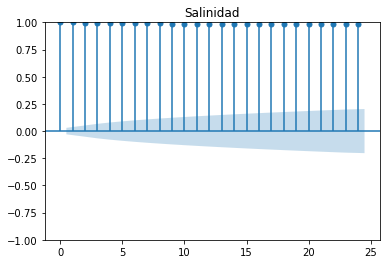

In [228]:
plot_acf(salinidad_pro, title=('Salinidad'), lags=24);

El comportamiento del autocorrelation plot en el caso de la salinidad es el mismo que en el caso de la temperatura. 

In [229]:

    plot_acf(humedad_pro, lags=24, title=('Humedad'));

Respecto a la humedad si que se aprecia una estacionalidad clara. No obstante si observamos la visualización de toda la humedad comprobamos que esa estacionalidad desaparece a partir de Septiembre, seguramente debido a que los riegos eran mas frecuentes durante el verano y menos durante el invierno. Si dividimos el dataset en invierno y verano, y observamos su estacionalidad:

In [230]:
humedad_verano = humedad_pro.loc[:'2021-09-01 00:00:00', :]

humedad_invierno = humedad_pro.loc['2021-09-02 00:00:00':, :]

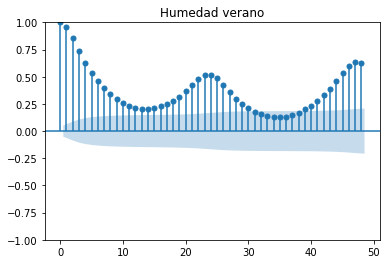

In [231]:

plot_acf(humedad_verano, lags=24, title=('Humedad verano'))
plot_acf(humedad_verano, lags=48, title=('Humedad verano'))
plot_acf(humedad_verano, lags=72, title=('Humedad verano'));

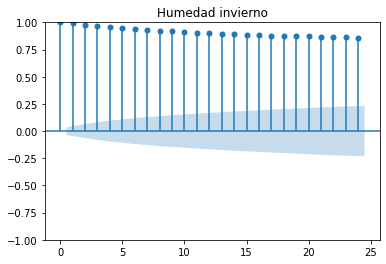

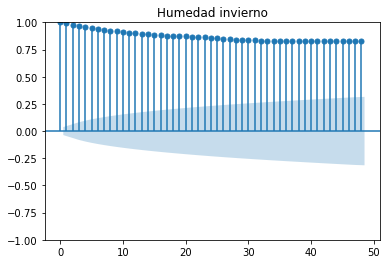

In [232]:
plot_acf(humedad_invierno, lags=24, title=('Humedad invierno'))
plot_acf(humedad_invierno, lags=48, title=('Humedad invierno'))
plot_acf(humedad_invierno, lags=72, title=('Humedad invierno'));

Vemos que la estacionalidad se aprecia en verano, pero no en invierno. Parece que dicha estacionalidad puede ser debida a que se ha programado un riego en el verano por las altas temperaturas. 

En invierno al bajar las temperaturas parece que no se riega tanto y desaparece la estacionalidad.

## STACIONARITY

Vamos a ver si las diferentes series que tenemos tienen estacionaridad o no. Empecemos con las series de temperatura

In [233]:

result_temp = adfuller(temperatura_pro.values)
result_temp

(-0.41043311783614933,
 0.9083421924614484,
 27,
 4264,
 {'1%': -3.431884531202631,
  '5%': -2.862218071099101,
  '10%': -2.5671309424885336},
 -14662.315298760826)

In [234]:

result_sal = adfuller(salinidad_pro.values)
result_sal

(-0.5680072520244441,
 0.878048461978824,
 28,
 4263,
 {'1%': -3.431884891384828,
  '5%': -2.8622182302135886,
  '10%': -2.567131027193441},
 -35831.093397744924)

In [235]:
result_humedad_verano = adfuller(humedad_verano.values)
result_humedad_verano

(-4.924206069777941,
 3.128186872345807e-05,
 24,
 1438,
 {'1%': -3.4349056408696814,
  '5%': -2.863552005375758,
  '10%': -2.5678411776130114},
 -23.820237288163753)

In [236]:
result_humedad_invierno = adfuller(humedad_invierno.values)
result_humedad_invierno[1]

0.3669564049808751

In [237]:
fuller_df = pd.DataFrame([result_temp[1], result_sal[1], result_humedad_verano[1], result_humedad_invierno[1]], index=['adfuller_temp', 'adfuller_sal', 'adfuller_hum_verano', 'adfuller_hum_invierno'], columns=['pvalue'])

fuller_df

pvalue
adfuller_temp          0.908342
adfuller_sal           0.878048
adfuller_hum_verano    0.000031
adfuller_hum_invierno  0.366956

Parece que tanto la temperatura, como la salinidad no son series estacionarias ya que su p_value > 0.05. La humedad en verano si que es estacionaria pero la humedad en invierno tampoco sería una serie estacionaria.

Resumiendo:

- La serie de humedad durante el verano es estacionaria con un lag de 24 horas, esta es una estacionalidad artificial al parecer debido a un riego automatico diario.
- El resto de series: Temperatura, salinidad y humedad en invierno son series no estacionales o con una estacionalidad muy pequeña.
- Las series de temperatura, salinidad y humedad invernal NO SON ESTACIONARIAS ya que su p_value > 0.05
- La serie de humedad de verano ES ESTACIONARIA (p_value < 0.05)


## MODELO ARIMA

Empecemos por las Series que sabemos que NO son ESTACIONARIAS y que no tienen practicamente SEASONALITY que son aquellos valores de temperatura y salinidad equivalentes a las profundidades de 40 a 80 cm.

Correremos 4 modelos ARIMA para temperatura y 4 modelos ARIMA para Salinidad. Pero primero dividiremos el DataFrame en Train y Test, dejaremos un test equivalente a 3 dias

In [238]:
X_train_temperatura = temperatura_pro[:-72]
X_test_temperatura = temperatura_pro[-72:]

X_train_salinidad = salinidad_pro[:-72]
X_test_salinidad = salinidad_pro[-72:]

print('X_train_temperatura shape :', X_train_temperatura.shape)
print('X_test_temperatura shape :', X_test_temperatura.shape)
print('X_train_salinidad shape :', X_train_salinidad.shape)
print('X_test_salinidad shape :', X_test_salinidad.shape)

X_train_temperatura

X_train_temperatura shape : (4220, 1)
X_test_temperatura shape : (72, 1)
X_train_salinidad shape : (4220, 1)
X_test_salinidad shape : (72, 1)


T
Fecha                         
2021-07-01 00:00:00  22.373000
2021-07-01 01:00:00  22.316800
2021-07-01 02:00:00  22.243000
2021-07-01 03:00:00  22.172333
2021-07-01 04:00:00  22.085333
...                        ...
2021-12-28 19:00:00  11.708667
2021-12-28 20:00:00  11.692667
2021-12-28 21:00:00  11.673333
2021-12-28 22:00:00  11.663000
2021-12-28 23:00:00  11.657200

[4220 rows x 1 columns]

In [239]:
def graph (test, train, prediction, parametro, titulo):

    plt.figure(figsize=(10,8))
    plt.plot(train.values[-1000:])
    plt.plot(test.values)
    plt.plot(prediction)
    plt.ylabel(parametro)
    plt.xlabel('tiempo en horas')
    plt.title(titulo)

In [240]:
modelT = auto_arima(X_train_temperatura,
                    start_p=1,
                    start_q=1,
                    max_d=3,
                    max_p=5,
                    max_q=5,
                    trace=True,
                    stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-13098.499, Time=1.96 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-8366.313, Time=0.55 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-13085.526, Time=0.71 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-11003.794, Time=1.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-8364.935, Time=0.28 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-13086.695, Time=4.67 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-13287.002, Time=3.49 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-12253.426, Time=2.96 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-13648.205, Time=6.28 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-13661.601, Time=6.38 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-13610.451, Time=6.05 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-13651.980, Time=7.69 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-13308.275, Time=8.52 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-13669.696, Time=7.21 sec
 ARIMA(

In [241]:
modelS50 = auto_arima(X_train_salinidad,
                    start_p=1,
                    start_q=1,
                    max_d=3,
                    max_p=5,
                    max_q=5,
                    trace=True,
                    stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-34632.902, Time=1.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-32430.797, Time=0.79 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-34517.837, Time=0.82 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-34322.747, Time=2.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-32431.254, Time=0.33 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-34630.462, Time=0.77 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-34622.972, Time=2.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-34521.634, Time=4.88 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-34629.091, Time=1.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-34639.112, Time=1.80 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-34805.644, Time=6.76 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-34617.679, Time=3.52 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-34809.577, Time=1.85 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-34774.420, Time=1.10 sec
 ARIM

In [242]:
modelT.fit(X_train_temperatura)

ARIMA(order=(2, 1, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [243]:
modelS50.fit(X_train_salinidad)

ARIMA(order=(4, 1, 4), scoring_args={}, suppress_warnings=True)

In [244]:
predictionsT = modelT.predict(72)

In [245]:
predictions_S50 = modelS50.predict(72)

In [246]:
graph(X_test_temperatura, predictionsT, 'Temperatura', titulo = 'Temperatura media')

MAE_temp = mean_absolute_error(predictionsT, X_test_temperatura)

TypeError: graph() missing 1 required positional argument: 'parametro'

No tenemos una predicción muy buena. Vamos a intentar suavizar la grafica con el metodo rolling y el parametro window a 100 a ver si conseguimos bajar algo el score

In [249]:
temp_roll = temperatura_pro.rolling(window=100).mean().dropna()
temp_roll

T
Fecha                         
2021-07-05 03:00:00  22.717030
2021-07-05 04:00:00  22.726276
2021-07-05 05:00:00  22.735144
2021-07-05 06:00:00  22.743888
2021-07-05 07:00:00  22.752418
...                        ...
2021-12-31 19:00:00  11.339232
2021-12-31 20:00:00  11.330509
2021-12-31 21:00:00  11.320922
2021-12-31 22:00:00  11.310550
2021-12-31 23:00:00  11.299468

[4193 rows x 1 columns]

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(temperatura_pro)
plt.plot(temp_roll)

In [ ]:
X_train_temperatura_roll = temp_roll[:-72]
X_test_temperatura_roll = temp_roll[-72:]

In [ ]:
modelT = auto_arima(X_train_temperatura_roll,
                    start_p=1,
                    start_q=1,
                    max_d=3,
                    max_p=5,
                    max_q=5,
                    trace=True,
                    stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-47555.909, Time=1.19 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-42893.407, Time=0.55 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-47517.001, Time=0.53 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-43891.550, Time=0.65 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=-42887.318, Time=1.41 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=-47793.322, Time=1.89 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=-44680.357, Time=0.91 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=-48021.980, Time=1.44 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=-48054.029, Time=1.81 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=-47824.942, Time=1.07 sec
 ARIMA(4,2,2)(0,0,0)[0]             : AIC=-48049.108, Time=1.95 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=-42881.170, Time=5.03 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=-48090.032, Time=1.80 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=-47843.712, Time=1.46 sec
 ARIM

In [ ]:
modelT.fit(X_train_temperatura_roll)

ARIMA(order=(3, 2, 4), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
predictT_roll = modelT.predict(72)

0.11650942513332388

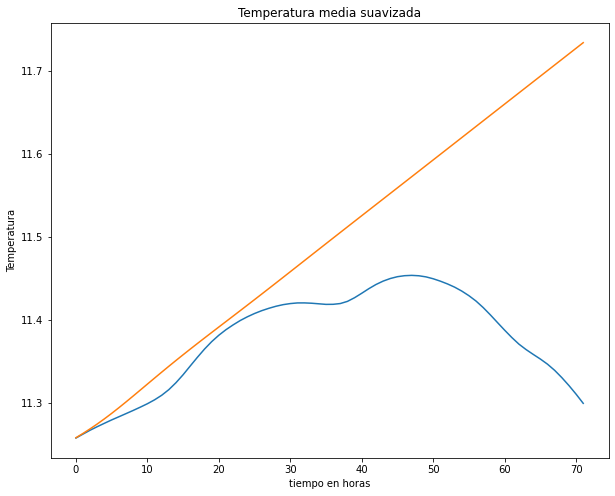

In [ ]:
graph(X_test_temperatura_roll, predictT_roll, 'Temperatura', 'Temperatura media suavizada')


MAE_temp_roll = mean_absolute_error(predictT_roll, X_test_temperatura_roll)

MAE_temp_roll

Hemos bajado el MAE 0.3 puntos la diferencia de temperatura entre test y la predicha. No obstante seguimos observando que no es una muy buena aproximación

In [ ]:
temp_log = np.log(temp_roll)


In [ ]:
X_train_temperatura_log = temp_log[:-72]
X_test_temperatura_log = temp_log[-72:]

In [ ]:
modelT = auto_arima(X_train_temperatura_log,
                    start_p=1,
                    start_q=1,
                    max_d=3,
                    max_p=5,
                    max_q=5,
                    trace=True,
                    stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-70003.596, Time=0.87 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-65840.134, Time=0.59 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-69994.082, Time=0.75 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-67966.031, Time=0.60 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=-66001.916, Time=1.51 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=-70171.731, Time=1.08 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=-68766.267, Time=2.38 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=-70404.790, Time=1.52 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=-70426.930, Time=2.65 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=-70183.052, Time=1.78 sec
 ARIMA(4,2,2)(0,0,0)[0]             : AIC=-70360.961, Time=1.66 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=-70365.213, Time=1.79 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=-70428.375, Time=2.04 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=-70237.469, Time=2.00 sec
 ARIM

In [ ]:
modelT.fit(X_train_temperatura_log)

ARIMA(order=(2, 2, 4), scoring_args={}, suppress_warnings=True)

In [ ]:
predictTlog = modelT.predict(72)

0.00962054952643316

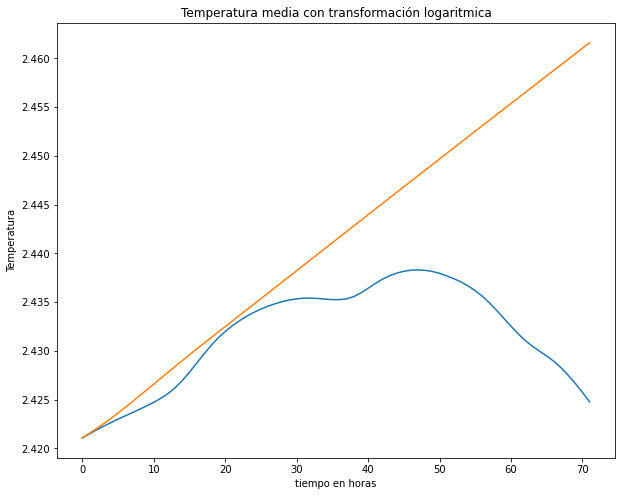

In [ ]:
graph(X_test_temperatura_log, predictTlog, 'Temperatura', 'Temperatura media con transformación logaritmica')


MAE_temp_log = mean_absolute_error(predictTlog, X_test_temperatura_log)

MAE_temp_log

In [ ]:
graph(X_test_salinidad, predictions_S50, 'Salinidad', 'Salinidad media')


MAE_sal = mean_absolute_error(predictions_S50, X_test_salinidad)

MAE_sal

0.00971779595310028

In [250]:
sal_roll = salinidad_pro.rolling(window=100).mean().dropna()
sal_roll

S
Fecha                        
2021-07-05 03:00:00  0.951169
2021-07-05 04:00:00  0.951725
2021-07-05 05:00:00  0.952387
2021-07-05 06:00:00  0.953266
2021-07-05 07:00:00  0.954228
...                       ...
2021-12-31 19:00:00  0.507472
2021-12-31 20:00:00  0.507183
2021-12-31 21:00:00  0.506877
2021-12-31 22:00:00  0.506555
2021-12-31 23:00:00  0.506211

[4193 rows x 1 columns]

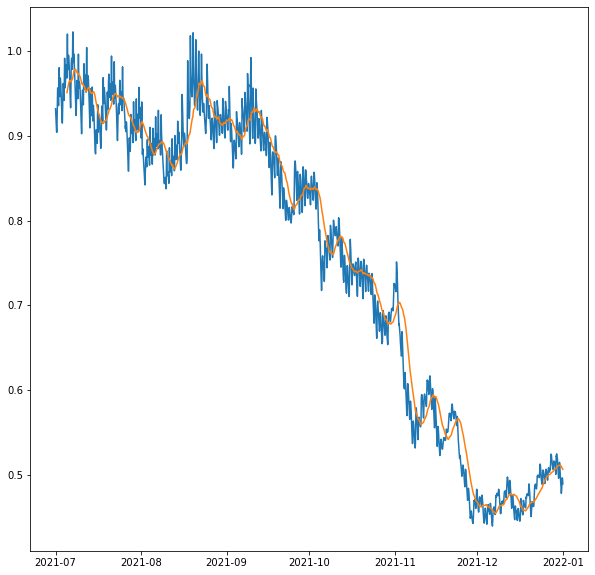

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(salinidad_pro)
plt.plot(sal_roll)

In [ ]:
X_train_salinidad_roll = sal_roll[:-72]
X_test_salinidad_roll = sal_roll[-72:]

In [ ]:
modelSroll = auto_arima(X_train_salinidad_roll,
                    start_p=1,
                    start_q=1,
                    max_d=3,
                    max_p=5,
                    max_q=5,
                    trace=True,
                    stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-68556.640, Time=0.93 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-66143.674, Time=0.35 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-68458.026, Time=0.58 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-68115.980, Time=1.74 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=-68640.835, Time=1.57 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=-68566.392, Time=1.91 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=-68548.017, Time=4.16 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=-68601.571, Time=1.69 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=-68535.150, Time=1.64 sec


c:\Users\Usuario\anaconda3\envs\Machine_Learning\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning:

Error fitting  ARIMA(3,2,0)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "c:\Users\Usuario\anaconda3\envs\Machine_Learning\lib\site-packages\pmdarima\arima\_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "c:\Users\Usuario\anaconda3\envs\Machine_Learning\lib\site-packages\pmdarima\arima\arima.py", line 597, in fit
    self._fit(y, X, **fit_args)
  File "c:\Users\Usuario\anaconda3\envs\Machine_Learning\lib\site-packages\pmdarima\arima\arima.py", line 518, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "c:\Users\Usuario\anaconda3\envs\Machine_Learning\lib\site-packages\pmdarima\arima\arima.py", line 508, in _fit_wrapper
    return arima, arima.fit(start_params=start_params,
  File "c:\Users\Usuario\anaconda3\env

 ARIMA(3,2,0)(0,0,0)[0]             : AIC=inf, Time=nan sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=-68742.303, Time=3.29 sec
 ARIMA(4,2,2)(0,0,0)[0]             : AIC=-68834.047, Time=4.06 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=-68809.480, Time=5.22 sec
 ARIMA(5,2,2)(0,0,0)[0]             : AIC=-68825.560, Time=5.81 sec
 ARIMA(4,2,3)(0,0,0)[0]             : AIC=-68858.281, Time=2.89 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=-68776.636, Time=2.89 sec
 ARIMA(5,2,3)(0,0,0)[0]             : AIC=-66182.096, Time=2.84 sec
 ARIMA(4,2,4)(0,0,0)[0]             : AIC=-68869.690, Time=1.13 sec
 ARIMA(3,2,4)(0,0,0)[0]             : AIC=-68847.031, Time=3.50 sec
 ARIMA(5,2,4)(0,0,0)[0]             : AIC=-68878.643, Time=6.08 sec
 ARIMA(5,2,5)(0,0,0)[0]             : AIC=-68884.587, Time=3.31 sec
 ARIMA(4,2,5)(0,0,0)[0]             : AIC=-68900.438, Time=8.09 sec
 ARIMA(3,2,5)(0,0,0)[0]             : AIC=-68848.313, Time=4.60 sec
 ARIMA(4,2,5)(0,0,0)[0] intercept   : AIC=-68937.059, Ti

In [ ]:
modelSroll.fit(X_train_salinidad_roll)

ARIMA(order=(4, 2, 5), scoring_args={}, suppress_warnings=True)

In [ ]:
predictSroll = modelSroll.predict(72)

0.0015455158370357635

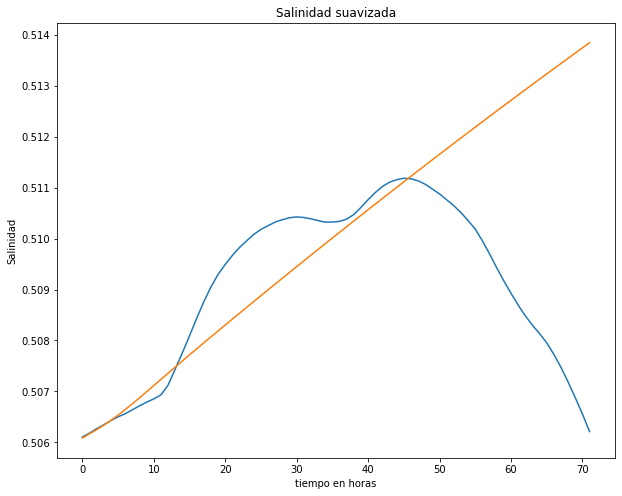

In [ ]:
graph(X_test_salinidad_roll, predictSroll, 'Salinidad', 'Salinidad suavizada')


MAE_sal_roll = mean_absolute_error(predictSroll, X_test_salinidad_roll)

MAE_sal_roll

Debido a que la humedad en verano tiene mucha estacionalidad vamos a realizar un tratamiento de los datos para reducir dicha estacionalidad. Para ello vamos a utilizar el descompose aditivo y multiplicativo y vamos a eliminar la estacionalidad

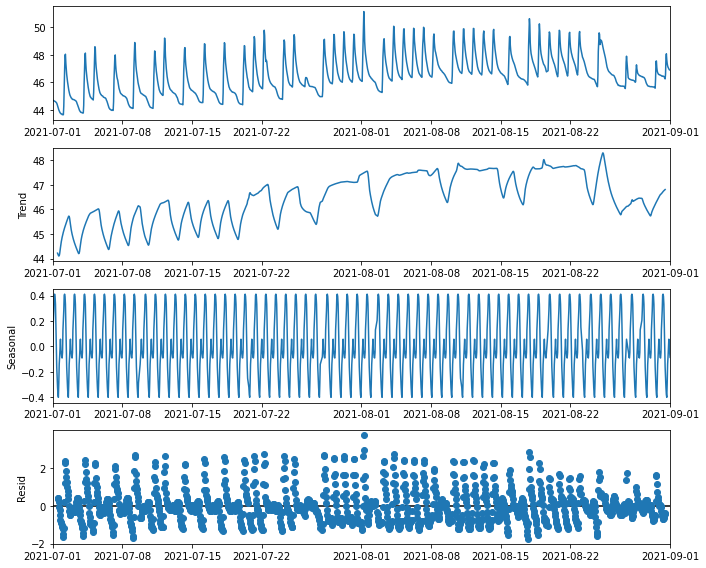

In [255]:
result_verano_add = seasonal_decompose(humedad_verano, model='additive',period=24)

plt.rcParams.update({'figure.figsize': (10,8)})
result_verano_add.plot();

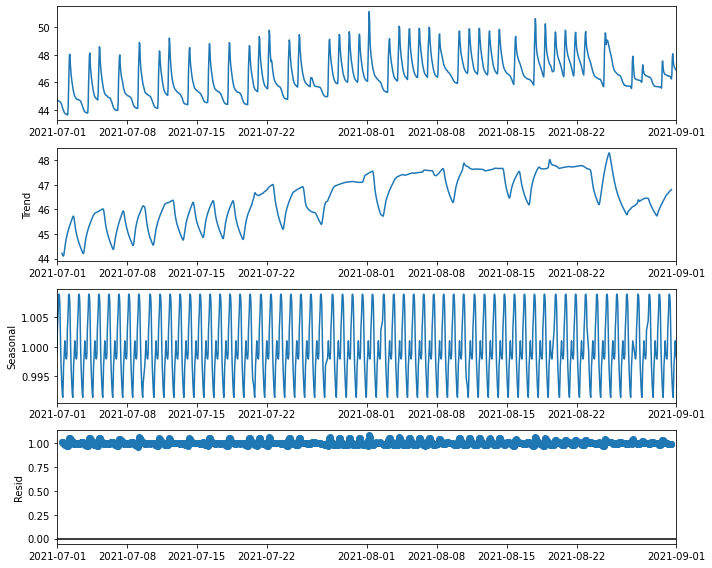

In [253]:
result_verano_mult = seasonal_decompose(humedad_verano, model='multiplicative', period=24)

plt.rcParams.update({'figure.figsize': (10,8)})
result_verano_mult.plot();

In [256]:
humedad_verano_des = humedad_verano['H'].values - result_verano_add.seasonal

plt.figure(figsize=(10,8))
plt.plot(humedad_verano)
plt.plot(humedad_verano_des)

humedad_verano

H
Fecha                         
2021-07-01 00:00:00  44.708000
2021-07-01 01:00:00  44.688400
2021-07-01 02:00:00  44.680333
2021-07-01 03:00:00  44.654333
2021-07-01 04:00:00  44.644333
...                        ...
2021-08-31 20:00:00  47.031667
2021-08-31 21:00:00  46.965333
2021-08-31 22:00:00  46.914333
2021-08-31 23:00:00  46.902000
2021-09-01 00:00:00  46.886000

[1463 rows x 1 columns]

In [257]:
hum_total = pd.concat([humedad_verano_des, humedad_invierno], axis=1)

hum_total['seasonal'] = hum_total['seasonal'].fillna(0)

hum_total['H'] = hum_total['H'].fillna(0)

print(hum_total)

hum_total['Htot'] = hum_total['seasonal'] + hum_total['H']

hum_total = hum_total['Htot']

hum_total

                      seasonal          H
Fecha                                    
2021-07-01 00:00:00  44.755571   0.000000
2021-07-01 01:00:00  44.558512   0.000000
2021-07-01 02:00:00  44.475497   0.000000
2021-07-01 03:00:00  44.372264   0.000000
2021-07-01 04:00:00  44.242704   0.000000
...                        ...        ...
2021-12-31 19:00:00   0.000000  43.298000
2021-12-31 20:00:00   0.000000  43.273333
2021-12-31 21:00:00   0.000000  43.276000
2021-12-31 22:00:00   0.000000  43.271000
2021-12-31 23:00:00   0.000000  43.262800

[4272 rows x 2 columns]


Fecha
2021-07-01 00:00:00    44.755571
2021-07-01 01:00:00    44.558512
2021-07-01 02:00:00    44.475497
2021-07-01 03:00:00    44.372264
2021-07-01 04:00:00    44.242704
                         ...    
2021-12-31 19:00:00    43.298000
2021-12-31 20:00:00    43.273333
2021-12-31 21:00:00    43.276000
2021-12-31 22:00:00    43.271000
2021-12-31 23:00:00    43.262800
Name: Htot, Length: 4272, dtype: float64

In [ ]:
X_train_humedad = hum_total[:-72]
X_test_humedad = hum_total[-72:]

X_train_humedad



Fecha
2021-07-01 00:00:00    44.755571
2021-07-01 01:00:00    44.558512
2021-07-01 02:00:00    44.475497
2021-07-01 03:00:00    44.372264
2021-07-01 04:00:00    44.242704
                         ...    
2021-12-28 19:00:00    43.397000
2021-12-28 20:00:00    43.399667
2021-12-28 21:00:00    43.391000
2021-12-28 22:00:00    43.373333
2021-12-28 23:00:00    43.353200
Name: Htot, Length: 4200, dtype: float64

In [ ]:
modelH = auto_arima(X_train_humedad,
                    start_p=1,
                    start_q=1,
                    max_p=5,
                    max_q=5,
                    max_d=3,
                    trace=True,
                    stepwise=True)



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1704.919, Time=1.87 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=558.769, Time=0.52 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1283.336, Time=0.45 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1539.397, Time=0.94 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=556.776, Time=0.38 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1747.890, Time=1.82 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1729.467, Time=0.59 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-1782.563, Time=3.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-1732.916, Time=0.77 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-1893.610, Time=3.75 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-1836.552, Time=1.38 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-1893.992, Time=5.11 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-1877.661, Time=1.76 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=-2050.965, Time=9.62 sec
 ARIMA(4,1,2)(0,0,0)[0]

In [ ]:
modelH.fit(X_train_humedad)


ARIMA(order=(5, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
predictH = modelH.predict(72)

0.25702278208948737

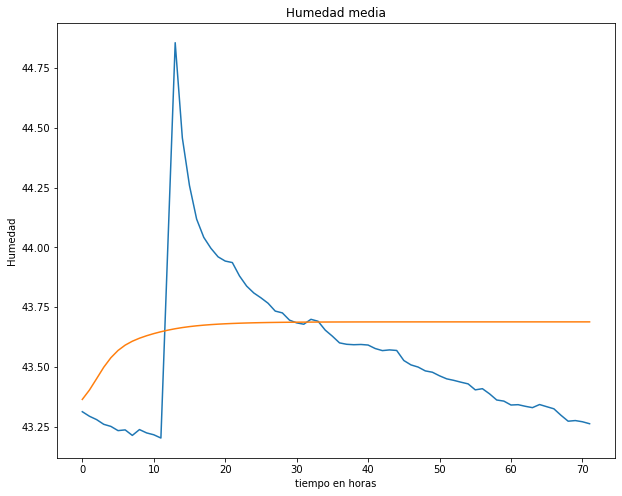

In [ ]:
graph(X_test_humedad, predictH, 'Humedad', 'Humedad media')

MAE_hum = mean_absolute_error(predictH, X_test_humedad)

MAE_hum

Como pasaba con la temperatura y la salinidad, el ruido presente hace que las predicciones no salgan del todo bien, si aplicamos a nuestro dataframe de humedad un rolling con un window de 100

In [258]:
hum_roll = hum_total.rolling(window=100).mean().dropna()

hum_roll



Fecha
2021-07-05 03:00:00    44.929539
2021-07-05 04:00:00    44.942907
2021-07-05 05:00:00    44.968850
2021-07-05 06:00:00    45.006015
2021-07-05 07:00:00    45.043524
                         ...    
2021-12-31 19:00:00    43.554251
2021-12-31 20:00:00    43.550538
2021-12-31 21:00:00    43.546778
2021-12-31 22:00:00    43.542844
2021-12-31 23:00:00    43.539002
Name: Htot, Length: 4173, dtype: float64

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(hum_total)
plt.plot(hum_roll)

In [ ]:
X_train_humedad_roll = hum_roll[:-72]
X_test_humedad_roll = hum_roll[-72:]


In [ ]:
modelHroll = auto_arima(X_train_humedad_roll,
                    start_p=1,
                    start_q=1,
                    max_d=3,
                    max_p=5,
                    max_q=5,
                    trace=True,
                    stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-36285.020, Time=0.67 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-34016.826, Time=0.32 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-35900.694, Time=0.40 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-36145.509, Time=0.76 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=-36358.523, Time=1.16 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=-36329.801, Time=0.60 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=-36295.666, Time=0.79 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=-36401.071, Time=0.88 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=-36265.371, Time=0.98 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=-34007.374, Time=2.26 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=-36447.338, Time=1.08 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=-36247.822, Time=1.83 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=-36545.210, Time=0.97 sec
 ARIMA(4,2,3)(0,0,0)[0]             : AIC=-36581.027, Time=1.33 sec
 ARIM

In [ ]:
modelHroll.fit(X_train_humedad_roll)

ARIMA(order=(3, 2, 5), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
predictHroll = modelHroll.predict(72)

In [ ]:
graph(X_test_humedad_roll, predictHroll, 'Humedad', 'Humedad media suavizada')

MAE_hum_roll = mean_absolute_error(predictHroll, X_test_humedad_roll)

MAE_hum_roll

0.14431881115120643

In [ ]:
def graph_all (X_train, X_test, prediction, parametro, titulo):

    X_train['Empty'] = 
    df1 = pd.concat([X_train['Empty'], X_test])
    serie = pd.Series(prediction)
    df2 = pd.concat([X_train['Empty'], serie])
    plt.figure(figsize=(10,8))
    plt.plot(X_train.values[-1000:], color = 'blue')
    plt.plot(df1.values, color = 'red' )
    plt.plot(df2.values, color = 'green')
    print(df1.shape)
    print(len(df2))
    plt.ylabel(parametro)
    plt.xlabel('tiempo en horas')
    plt.title(titulo)

SyntaxError: invalid syntax (1288499893.py, line 3)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_15492\3310367608.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Usuario\AppData\Local\Temp\ipykernel_15492\3310367608.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



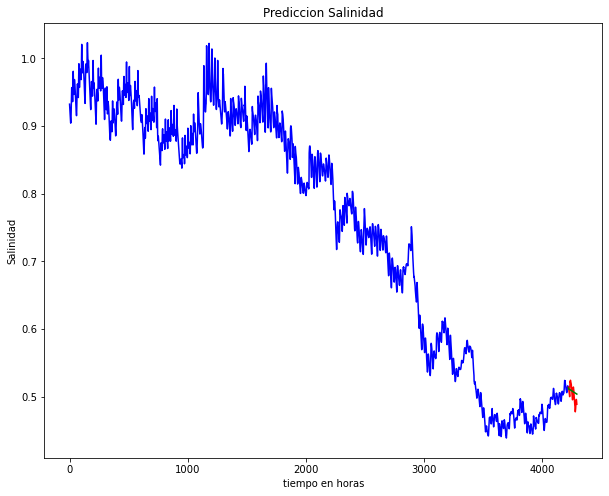

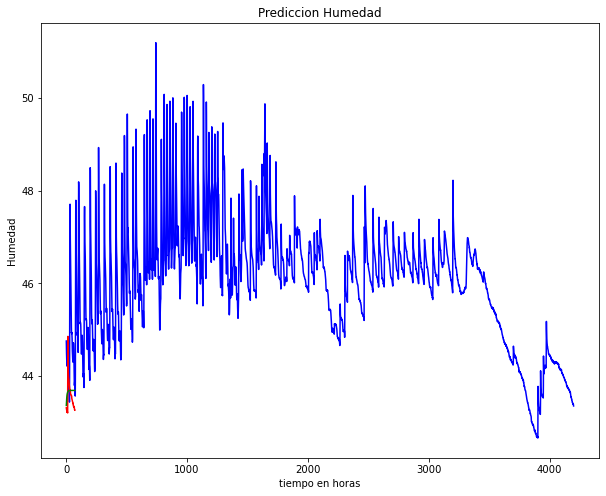

In [ ]:
graph_all(X_train_temperatura, X_test_temperatura, predictionsT, 'Temperatura', 'Prediccion Temperatura')
graph_all(X_train_salinidad, X_test_salinidad, predictions_S50, 'Salinidad', 'Prediccion Salinidad')
graph_all(X_train_humedad, X_test_humedad, predictH, 'Humedad', 'Prediccion Humedad')

C:\Users\Usuario\AppData\Local\Temp\ipykernel_15492\3310367608.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Usuario\AppData\Local\Temp\ipykernel_15492\3310367608.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



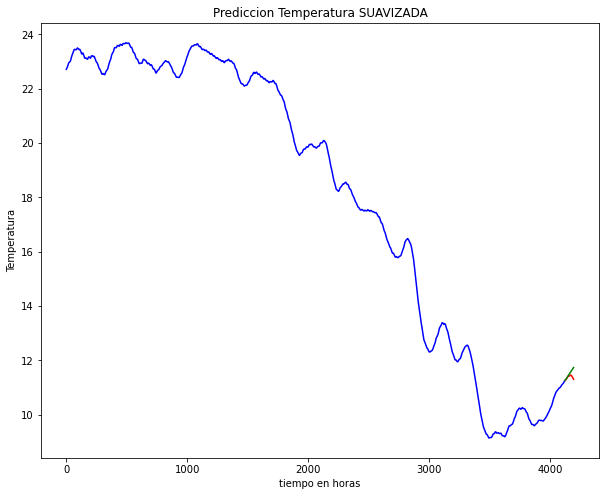

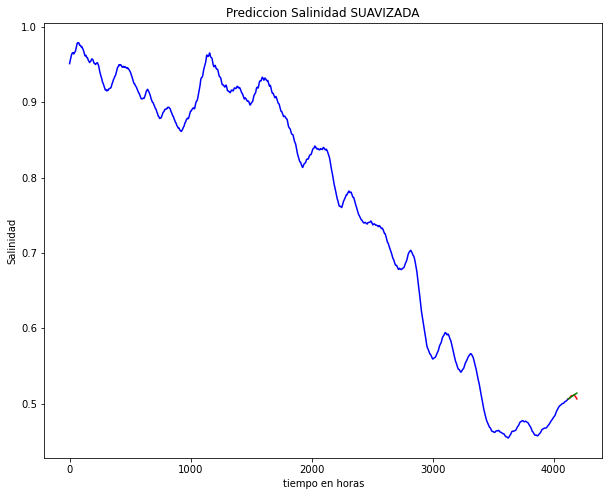

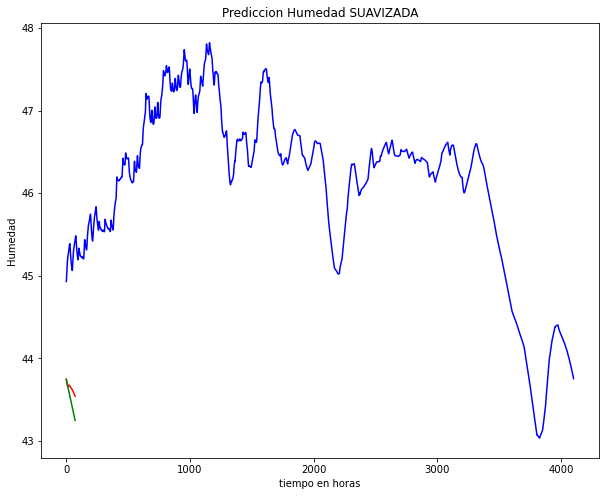

In [ ]:
graph_all(X_train_temperatura_roll, X_test_temperatura_roll, predictT_roll, 'Temperatura', 'Prediccion Temperatura SUAVIZADA')
graph_all(X_train_salinidad_roll, X_test_salinidad_roll, predictSroll, 'Salinidad', 'Prediccion Salinidad SUAVIZADA')
graph_all(X_train_humedad_roll, X_test_humedad_roll, predictHroll, 'Humedad', 'Prediccion Humedad SUAVIZADA')



# MODEL DE REGRESIÓN

Vamos a probar un modelo de Regresion como el Random Forest, para ver si conseguimos mejorar nuestro modelo. Primero vamos a transformar las series de temperatura, salinidad y humedad para poder trabajar con este modelo. Para ello vamos a aplicarle un shift 12 veces

In [49]:

for i in range(12,0,-1):
    temperatura_pro['t-'+str(i)] = temperatura_pro['T'].shift(i)

temp_clean = temperatura_pro.dropna()

temp_clean

T       t-12       t-11       t-10        t-9  \
Fecha                                                                        
2021-07-01 12:00:00  21.731000  22.373000  22.316800  22.243000  22.172333   
2021-07-01 13:00:00  21.931333  22.316800  22.243000  22.172333  22.085333   
2021-07-01 14:00:00  22.240000  22.243000  22.172333  22.085333  22.008000   
2021-07-01 15:00:00  22.584000  22.172333  22.085333  22.008000  21.931600   
2021-07-01 16:00:00  22.880667  22.085333  22.008000  21.931600  21.858000   
...                        ...        ...        ...        ...        ...   
2021-12-31 19:00:00  10.974333  10.619333  10.535600  10.426000  10.339000   
2021-12-31 20:00:00  10.937667  10.535600  10.426000  10.339000  10.297000   
2021-12-31 21:00:00  10.888000  10.426000  10.339000  10.297000  10.329000   
2021-12-31 22:00:00  10.830000  10.339000  10.297000  10.329000  10.383600   
2021-12-31 23:00:00  10.760800  10.297000  10.329000  10.383600  10.495000   

                           t-8        t-7        t-6        t-5        t-4  \
Fecha                                                                        
2021-07-01 12:00:00  22.085333  22.008000  21.931600  21.858000  21.761667   
2021-07-01 13:00:00  22.008000  21.931600  21.858000  21.761667  21.704667   
2021-07-01 14:00:00  21.931600  21.858000  21.761667  21.704667  21.679600   
2021-07-01 15:00:00  21.858000  21.761667  21.704667  21.679600  21.667000   
2021-07-01 16:00:00  21.761667  21.704667  21.679600  21.667000  21.731000   
...                        ...        ...        ...        ...        ...   
2021-12-31 19:00:00  10.297000  10.329000  10.383600  10.495000  10.686667   
2021-12-31 20:00:00  10.329000  10.383600  10.495000  10.686667  10.845000   
2021-12-31 21:00:00  10.383600  10.495000  10.686667  10.845000  10.926333   
2021-12-31 22:00:00  10.495000  10.686667  10.845000  10.926333  10.970000   
2021-12-31 23:00:00  10.686667  10.845000  10.926333  10.970000  10.974333   

                           t-3        t-2        t-1  
Fecha                                                 
2021-07-01 12:00:00  21.704667  21.679600  21.667000  
2021-07-01 13:00:00  21.679600  21.667000  21.731000  
2021-07-01 14:00:00  21.667000  21.731000  21.931333  
2021-07-01 15:00:00  21.731000  21.931333  22.240000  
2021-07-01 16:00:00  21.931333  22.240000  22.584000  
...                        ...        ...        ...  
2021-12-31 19:00:00  10.845000  10.926333  10.970000  
2021-12-31 20:00:00  10.926333  10.970000  10.974333  
2021-12-31 21:00:00  10.970000  10.974333  10.937667  
2021-12-31 22:00:00  10.974333  10.937667  10.888000  
2021-12-31 23:00:00  10.937667  10.888000  10.830000  

[4280 rows x 13 columns]

Hacemos lo mismo con la salinidad y la humedad.

In [50]:

for i in range(12,0,-1):
    salinidad_pro['s-'+str(i)] = salinidad_pro['S'].shift(i)

sal_clean = salinidad_pro.dropna()

sal_clean

S      s-12      s-11      s-10       s-9  \
Fecha                                                                   
2021-07-01 12:00:00  0.908633  0.932267  0.929360  0.926933  0.924367   
2021-07-01 13:00:00  0.917700  0.929360  0.926933  0.924367  0.920933   
2021-07-01 14:00:00  0.930067  0.926933  0.924367  0.920933  0.916433   
2021-07-01 15:00:00  0.942480  0.924367  0.920933  0.916433  0.914040   
2021-07-01 16:00:00  0.951900  0.920933  0.916433  0.914040  0.910700   
...                       ...       ...       ...       ...       ...   
2021-12-31 19:00:00  0.495933  0.486167  0.481600  0.479500  0.477800   
2021-12-31 20:00:00  0.495333  0.481600  0.479500  0.477800  0.479067   
2021-12-31 21:00:00  0.493267  0.479500  0.477800  0.479067  0.481033   
2021-12-31 22:00:00  0.490900  0.477800  0.479067  0.481033  0.482640   
2021-12-31 23:00:00  0.488960  0.479067  0.481033  0.482640  0.486133   

                          s-8       s-7       s-6       s-5       s-4  \
Fecha                                                                   
2021-07-01 12:00:00  0.920933  0.916433  0.914040  0.910700  0.907533   
2021-07-01 13:00:00  0.916433  0.914040  0.910700  0.907533  0.904667   
2021-07-01 14:00:00  0.914040  0.910700  0.907533  0.904667  0.905080   
2021-07-01 15:00:00  0.910700  0.907533  0.904667  0.905080  0.904767   
2021-07-01 16:00:00  0.907533  0.904667  0.905080  0.904767  0.908633   
...                       ...       ...       ...       ...       ...   
2021-12-31 19:00:00  0.479067  0.481033  0.482640  0.486133  0.491100   
2021-12-31 20:00:00  0.481033  0.482640  0.486133  0.491100  0.494967   
2021-12-31 21:00:00  0.482640  0.486133  0.491100  0.494967  0.496000   
2021-12-31 22:00:00  0.486133  0.491100  0.494967  0.496000  0.496160   
2021-12-31 23:00:00  0.491100  0.494967  0.496000  0.496160  0.495933   

                          s-3       s-2       s-1  
Fecha                                              
2021-07-01 12:00:00  0.904667  0.905080  0.904767  
2021-07-01 13:00:00  0.905080  0.904767  0.908633  
2021-07-01 14:00:00  0.904767  0.908633  0.917700  
2021-07-01 15:00:00  0.908633  0.917700  0.930067  
2021-07-01 16:00:00  0.917700  0.930067  0.942480  
...                       ...       ...       ...  
2021-12-31 19:00:00  0.494967  0.496000  0.496160  
2021-12-31 20:00:00  0.496000  0.496160  0.495933  
2021-12-31 21:00:00  0.496160  0.495933  0.495333  
2021-12-31 22:00:00  0.495933  0.495333  0.493267  
2021-12-31 23:00:00  0.495333  0.493267  0.490900  

[4280 rows x 13 columns]

In [51]:

for i in range(12,0,-1):
    humedad_pro['t-'+str(i)] = humedad_pro['H'].shift(i)

hum_clean = humedad_pro.dropna()

hum_clean

H       t-12       t-11       t-10        t-9  \
Fecha                                                                        
2021-07-01 12:00:00  44.299000  44.708000  44.688400  44.680333  44.654333   
2021-07-01 13:00:00  44.191667  44.688400  44.680333  44.654333  44.644333   
2021-07-01 14:00:00  44.071667  44.680333  44.654333  44.644333  44.626667   
2021-07-01 15:00:00  43.992800  44.654333  44.644333  44.626667  44.612000   
2021-07-01 16:00:00  43.913333  44.644333  44.626667  44.612000  44.591000   
...                        ...        ...        ...        ...        ...   
2021-12-31 19:00:00  43.298000  43.404333  43.409200  43.387667  43.362000   
2021-12-31 20:00:00  43.273333  43.409200  43.387667  43.362000  43.357333   
2021-12-31 21:00:00  43.276000  43.387667  43.362000  43.357333  43.341000   
2021-12-31 22:00:00  43.271000  43.362000  43.357333  43.341000  43.342400   
2021-12-31 23:00:00  43.262800  43.357333  43.341000  43.342400  43.335667   

                           t-8        t-7        t-6        t-5        t-4  \
Fecha                                                                        
2021-07-01 12:00:00  44.644333  44.626667  44.612000  44.591000  44.560667   
2021-07-01 13:00:00  44.626667  44.612000  44.591000  44.560667  44.527333   
2021-07-01 14:00:00  44.612000  44.591000  44.560667  44.527333  44.481600   
2021-07-01 15:00:00  44.591000  44.560667  44.527333  44.481600  44.403667   
2021-07-01 16:00:00  44.560667  44.527333  44.481600  44.403667  44.299000   
...                        ...        ...        ...        ...        ...   
2021-12-31 19:00:00  43.357333  43.341000  43.342400  43.335667  43.330000   
2021-12-31 20:00:00  43.341000  43.342400  43.335667  43.330000  43.343000   
2021-12-31 21:00:00  43.342400  43.335667  43.330000  43.343000  43.334000   
2021-12-31 22:00:00  43.335667  43.330000  43.343000  43.334000  43.325200   
2021-12-31 23:00:00  43.330000  43.343000  43.334000  43.325200  43.298000   

                           t-3        t-2        t-1  
Fecha                                                 
2021-07-01 12:00:00  44.527333  44.481600  44.403667  
2021-07-01 13:00:00  44.481600  44.403667  44.299000  
2021-07-01 14:00:00  44.403667  44.299000  44.191667  
2021-07-01 15:00:00  44.299000  44.191667  44.071667  
2021-07-01 16:00:00  44.191667  44.071667  43.992800  
...                        ...        ...        ...  
2021-12-31 19:00:00  43.343000  43.334000  43.325200  
2021-12-31 20:00:00  43.334000  43.325200  43.298000  
2021-12-31 21:00:00  43.325200  43.298000  43.273333  
2021-12-31 22:00:00  43.298000  43.273333  43.276000  
2021-12-31 23:00:00  43.273333  43.276000  43.271000  

[4280 rows x 13 columns]

Ahora definimos X e Y y estos a su vez lo dividimos en train y test. Recordemos que queríamos conocer la previsión en los próximos 3 dias, es decir, 72 horas

In [52]:
X_temp = temp_clean.loc[:, 't-12':]
y_temp = temp_clean.loc[:, 'T']

X_sal = sal_clean.loc[:, 's-12':]
y_sal = sal_clean.loc[:, 'S']

X_hum = hum_clean.loc[:, 't-12':]
y_hum = hum_clean.loc[:, 'H']

In [53]:
X_train_temp = X_temp.iloc[:-72]
y_train_temp = y_temp.iloc[:-72]

X_test_temp = X_temp.iloc[-72:]
y_test_temp = y_temp.iloc[-72:]
#-----------------------------------

X_train_sal = X_sal.iloc[:-72]
y_train_sal = y_sal.iloc[:-72]

X_test_sal = X_sal.iloc[-72:]
y_test_sal = y_sal.iloc[-72:]
#-----------------------------------

X_train_hum = X_hum.iloc[:-72]
y_train_hum = y_hum.iloc[:-72]

X_test_hum = X_hum.iloc[-72:]
y_test_hum = y_hum.iloc[-72:]

In [54]:
def make_RandomForestRegressor (X_train, y_train, X_test, y_test):
    
    # entrena el random forest
    rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, max_features=8)

    rf_model.fit(X_train, y_train)

    # muestra el mean_absolute_percentage_error de test

    predicted = rf_model.predict(X_test)

    return predicted

In [55]:
predict_temp_rfr = make_RandomForestRegressor(X_train_temp, y_train_temp, X_test_temp, y_test_temp)

predict_sal_rfr = make_RandomForestRegressor(X_train_sal, y_train_sal, X_test_sal, y_test_sal)

predict_hum_rfr = make_RandomForestRegressor(X_train_hum, y_train_hum, X_test_hum, y_test_hum)

In [97]:
def graph_all (X_train, X_test, prediction, parametro, titulo):

    df1 = pd.concat([X_train, X_test])
    serie = pd.Series(prediction)
    df2 = pd.concat([X_train, serie])
    plt.figure(figsize=(10,8))
    #plt.plot(X_train.values[-1000:], color = 'blue')
    plt.plot(df1.values[-500:], color = 'red' )
    plt.plot(df2.values[-500:], color = 'green')
    print(df1.shape)
    print(len(df2))
    plt.ylabel(parametro)
    plt.xlabel('tiempo en horas')
    plt.title(titulo)

(4281,)
4281
(4281,)
4281
(4281,)
4281


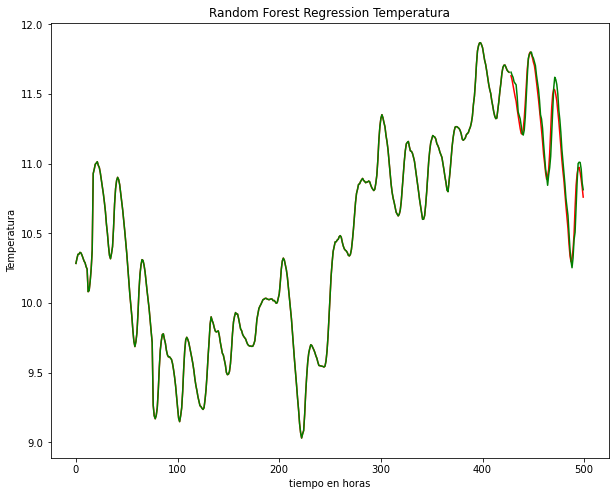

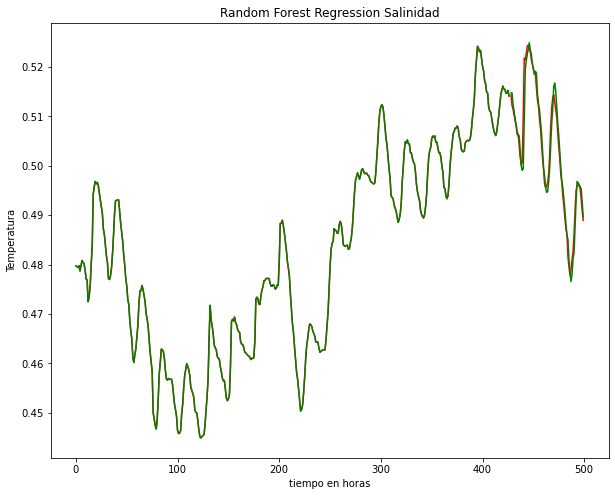

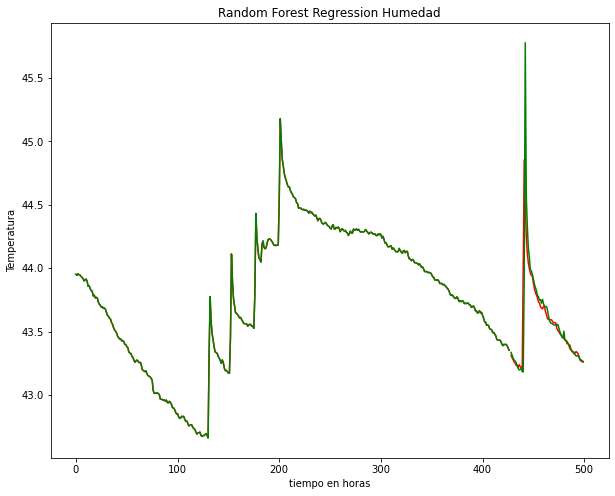

In [98]:
graph_all(y_train_temp,y_test_temp,predict_temp_rfr, 'Temperatura', 'Random Forest Regression Temperatura')
graph_all( y_train_sal,y_test_sal, predict_sal_rfr, 'Temperatura', 'Random Forest Regression Salinidad')
graph_all(y_train_hum,y_test_hum, predict_hum_rfr, 'Temperatura', 'Random Forest Regression Humedad')


In [60]:
MAE_temp_rfr = mean_absolute_error(predict_temp_rfr, y_test_temp)
MAE_sal_rfr = mean_absolute_error(predict_sal_rfr, y_test_sal)
MAE_hum_rfr = mean_absolute_error(predict_hum_rfr, y_test_hum)

print(MAE_sal_rfr, MAE_temp_rfr, MAE_hum_rfr)

0.00184081434227496 0.0651786440007305 0.06575685348160537


In [ ]:
def graph_all (X_train, X_test, prediction, parametro, titulo):

    X_train['Empty'] = None
    df1 = pd.concat([X_train['Empty'], X_test])
    serie = pd.Series(prediction)
    df2 = pd.concat([X_train['Empty'], serie])
    plt.figure(figsize=(10,8))
    plt.plot(X_train[-1000:].values, color = 'blue')
    plt.plot(df1.values, color = 'red' )
    plt.plot(df2.values, color = 'green')
    plt.ylabel(parametro)
    plt.xlabel('tiempo en horas')
    plt.title(titulo)

# PROPHETH

In [45]:
from datetime import datetime as dt

In [46]:
temperatura_pro = temperatura.reset_index()

salinidad_pro = salinidad.reset_index()

temperatura_pro

Fecha    T10    T20    T30    T40    T50    T60    T70  \
0     2021-07-01 00:08:29  21.94  22.88  22.73  21.90  22.58  21.89  21.32   
1     2021-07-01 00:18:46  21.84  22.87  22.72  21.90  22.56  21.91  21.34   
2     2021-07-01 00:29:03  21.82  22.83  22.69  21.90  22.58  21.92  21.33   
3     2021-07-01 00:39:20  21.72  22.75  22.65  21.92  22.62  21.93  21.36   
4     2021-07-01 00:49:37  21.71  22.75  22.61  21.88  22.60  21.93  21.35   
...                   ...    ...    ...    ...    ...    ...    ...    ...   
25044 2021-12-31 23:09:30   8.45   9.86  10.32  10.21  11.73  11.79  11.90   
25045 2021-12-31 23:19:47   8.35   9.79  10.32  10.24  11.73  11.80  11.90   
25046 2021-12-31 23:30:04   8.28   9.74  10.31  10.24  11.74  11.79  11.90   
25047 2021-12-31 23:40:21   8.23   9.73  10.27  10.24  11.74  11.79  11.90   
25048 2021-12-31 23:50:38   8.17   9.64  10.21  10.24  11.76  11.79  11.90   

         T80  
0      20.73  
1      20.73  
2      20.74  
3      20.73  
4      20.74  
...      ...  
25044  11.82  
25045  11.81  
25046  11.78  
25047  11.79  
25048  11.78  

[25049 rows x 9 columns]

In [114]:
temperatura_pro_hour = temperatura_pro.resample('D', on='Fecha').mean().reset_index()


df_50 = temperatura_pro_hour.loc[:,['Fecha','T50']]
df_60 = temperatura_pro_hour.loc[:,['Fecha','T60']]
df_70 = temperatura_pro_hour.loc[:,['Fecha','T70']]
df_80 = temperatura_pro_hour.loc[:,['Fecha','T80']]

df_50['T50'] = df_50['T50'].diff()
df_60['T60'] = df_60['T60'].diff()
df_70['T70'] = df_70['T70'].diff()
df_80['T80'] = df_80['T80'].diff()

df_50 = df_50.dropna()
df_60 = df_60.dropna()
df_70 = df_70.dropna()
df_80 = df_80.dropna()



(-7.083873313889353,
 4.5917286930582185e-10,
 1,
 181,
 {'1%': -3.467004502498507,
  '5%': -2.8776444997243558,
  '10%': -2.575355189707274},
 -295.7717919534608)

In [115]:

df_50 = df_50.rename({'Fecha':'ds', 'T50':'y'}, axis=1)
df_60 = df_60.rename({'Fecha':'ds', 'T60':'y'}, axis=1)
df_70 = df_70.rename({'Fecha':'ds', 'T70':'y'}, axis=1)
df_80 = df_80.rename({'Fecha':'ds', 'T80':'y'}, axis=1)

df_50


ds         y
1   2021-07-02  0.312967
2   2021-07-03  0.087654
3   2021-07-04  0.221165
4   2021-07-05  0.373500
5   2021-07-06  0.190655
..         ...       ...
179 2021-12-27  0.195683
180 2021-12-28  0.274460
181 2021-12-29 -0.004101
182 2021-12-30 -0.069353
183 2021-12-31 -0.340360

[183 rows x 2 columns]

In [116]:
df_50_train = df_60[:-3]

df_50_test = df_60[-3:]

df_60_train = df_60[:-3]

df_60_test = df_60[-3:]

df_70_train = df_60[:-3]

df_70_test = df_60[-3:]

df_80_train = df_60[:-3]

df_80_test = df_60[-3:]



In [117]:
m50 = Prophet()
m50.fit(df_50_train)

m60 = Prophet()
m60.fit(df_60_train);

m70 = Prophet()
m70.fit(df_70_train);

m80 = Prophet()
m80.fit(df_80_train);

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
c:\Users\Usuario\anaconda3\envs\Machine_Learning\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
c:\Users\Usuario\anaconda3\envs\Machine_Learning\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabli

In [118]:
future50 = m50.make_future_dataframe(periods=3, freq='D')

future60 = m60.make_future_dataframe(periods=3, freq='D')

future70 = m70.make_future_dataframe(periods=3, freq='D')

future80 = m80.make_future_dataframe(periods=3, freq='D')

future80


ds
0   2021-07-02
1   2021-07-03
2   2021-07-04
3   2021-07-05
4   2021-07-06
..         ...
178 2021-12-27
179 2021-12-28
180 2021-12-29
181 2021-12-30
182 2021-12-31

[183 rows x 1 columns]

In [119]:
forecast50 = m50.predict(future50)

forecast60 = m60.predict(future60)

forecast70 = m70.predict(future70)

forecast80 = m80.predict(future80)



c:\Users\Usuario\anaconda3\envs\Machine_Learning\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

c:\Users\Usuario\anaconda3\envs\Machine_Learning\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

c:\Users\Usuario\anaconda3\envs\Machine_Learning\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

c:\Users\Usuario\anaconda3\envs\Machine_Learning\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

c:\Users\Usuario\anaconda3\envs\Machine_Learning\lib\site-packages\fbprophet

In [74]:
forecast50

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0   2021-07-01  22.900201   22.118660   23.478330    22.900201    22.900201   
1   2021-07-02  22.912616   22.169477   23.449523    22.912616    22.912616   
2   2021-07-03  22.925031   22.222110   23.567215    22.925031    22.925031   
3   2021-07-04  22.937446   22.300430   23.662130    22.937446    22.937446   
4   2021-07-05  22.949861   22.421115   23.731435    22.949861    22.949861   
..         ...        ...         ...         ...          ...          ...   
179 2021-12-27  10.516474    9.973235   11.284283    10.516474    10.516474   
180 2021-12-28  10.456743    9.879669   11.158766    10.456743    10.456743   
181 2021-12-29  10.397012    9.681072   11.011565    10.397012    10.397012   
182 2021-12-30  10.337281    9.500661   10.861489    10.335889    10.338196   
183 2021-12-31  10.277550    9.507530   10.843321    10.270211    10.284706   

     additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
0         -0.103454             -0.103454             -0.103454 -0.103454   
1         -0.097951             -0.097951             -0.097951 -0.097951   
2         -0.033828             -0.033828             -0.033828 -0.033828   
3          0.089755              0.089755              0.089755  0.089755   
4          0.105571              0.105571              0.105571  0.105571   
..              ...                   ...                   ...       ...   
179        0.105571              0.105571              0.105571  0.105571   
180        0.075537              0.075537              0.075537  0.075537   
181       -0.035631             -0.035631             -0.035631 -0.035631   
182       -0.103454             -0.103454             -0.103454 -0.103454   
183       -0.097951             -0.097951             -0.097951 -0.097951   

     weekly_lower  weekly_upper  multiplicative_terms  \
0       -0.103454     -0.103454                   0.0   
1       -0.097951     -0.097951                   0.0   
2       -0.033828     -0.033828                   0.0   
3        0.089755      0.089755                   0.0   
4        0.105571      0.105571                   0.0   
..            ...           ...                   ...   
179      0.105571      0.105571                   0.0   
180      0.075537      0.075537                   0.0   
181     -0.035631     -0.035631                   0.0   
182     -0.103454     -0.103454                   0.0   
183     -0.097951     -0.097951                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper       yhat  
0                           0.0                         0.0  22.796748  
1                           0.0                         0.0  22.814665  
2                           0.0                         0.0  22.891203  
3                           0.0                         0.0  23.027201  
4                           0.0                         0.0  23.055432  
..                          ...                         ...        ...  
179                         0.0                         0.0  10.622046  
180                         0.0                         0.0  10.532281  
181                         0.0                         0.0  10.361381  
182                         0.0                         0.0  10.233827  
183                         0.0                         0.0  10.179599  

[184 rows x 16 columns]

In [120]:
def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast.
    
       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

cmp_df50 = make_comparison_dataframe(df_50, forecast50)
cmp_df60 = make_comparison_dataframe(df_60, forecast60)
cmp_df70 = make_comparison_dataframe(df_70, forecast70)
cmp_df80 = make_comparison_dataframe(df_80, forecast80)


In [91]:
df_50

ds          y
0   2021-07-01  22.532429
1   2021-07-02  22.845396
2   2021-07-03  22.933050
3   2021-07-04  23.154214
4   2021-07-05  23.527714
..         ...        ...
179 2021-12-27  11.995252
180 2021-12-28  12.269712
181 2021-12-29  12.265612
182 2021-12-30  12.196259
183 2021-12-31  11.855899

[184 rows x 2 columns]

In [121]:
def show_forecast(cmp_df, num_predictions, num_values, title):
    """Visualize the forecast."""
    
    def create_go(name, column, num, **kwargs):
        points = cmp_df.tail(num)
        args = dict(name=name, x=points.index, y=points[column], mode='lines')
        args.update(kwargs)
        return go.Scatter(**args)
    
    lower_bound = create_go('Lower Bound', 'yhat_lower', num_predictions,
                            line=dict(width=0),
                            marker=dict(color="aliceblue"))
    upper_bound = create_go('Upper Bound', 'yhat_upper', num_predictions,
                            line=dict(width=0),
                            marker=dict(color="aliceblue"),
                            fillcolor='rgba(68, 68, 68, 0.3)', 
                            fill='tonexty')
    forecast = create_go('Forecast', 'yhat', num_predictions,
                         line=dict(color='rgb(31, 119, 180)'))
    actual = create_go('Actual', 'y', num_values,
                       marker=dict(color="red"))
    
    # In this case the order of the series is important because of the filling
    data = [lower_bound, upper_bound, forecast, actual]

    layout = go.Layout(yaxis=dict(title='Posts'), title=title, showlegend = False)
    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)

show_forecast(cmp_df50, 3, 50, 'Temperatura 50')
show_forecast(cmp_df60, 3, 50, 'Temperatura 60')
show_forecast(cmp_df70, 3, 50, 'Temperatura 70')
show_forecast(cmp_df80, 3, 50, 'Temperatura 80')

# LSTM

Vamos a aplicar Recurrent Neural Network, concretamente Long Short-Term Memory (LSTM). Para ello utilizaremos de prueba los valores de temperatura equivalentes a la profundidad 60 cm.

In [152]:
temperatura_pro

T
Fecha                         
2021-07-01 00:00:00  22.373000
2021-07-01 01:00:00  22.316800
2021-07-01 02:00:00  22.243000
2021-07-01 03:00:00  22.172333
2021-07-01 04:00:00  22.085333
...                        ...
2021-12-31 19:00:00  10.974333
2021-12-31 20:00:00  10.937667
2021-12-31 21:00:00  10.888000
2021-12-31 22:00:00  10.830000
2021-12-31 23:00:00  10.760800

[4292 rows x 1 columns]

Escogemos los steps para realizar LSTM, en este caso vamos a utilizar un step = 12 horas

In [153]:
temperatura_pro_2 = temperatura_pro.copy()
emb_size = 12

'''
Montamos nuevas features con los lags
'''
for i in range(1, emb_size+1):
    temperatura_pro_2['lag' + str(i)] = temperatura_pro_2['T'].shift(i)
    
temperatura_pro_2.dropna(inplace=True)
temperatura_pro_2.reset_index(drop=True, inplace=True)

values = temperatura_pro_2.values

values

array([[21.731     , 21.667     , 21.6796    , ..., 22.243     ,
        22.3168    , 22.373     ],
       [21.93133333, 21.731     , 21.667     , ..., 22.17233333,
        22.243     , 22.3168    ],
       [22.24      , 21.93133333, 21.731     , ..., 22.08533333,
        22.17233333, 22.243     ],
       ...,
       [10.888     , 10.93766667, 10.97433333, ..., 10.297     ,
        10.339     , 10.426     ],
       [10.83      , 10.888     , 10.93766667, ..., 10.329     ,
        10.297     , 10.339     ],
       [10.7608    , 10.83      , 10.888     , ..., 10.3836    ,
        10.329     , 10.297     ]])

In [154]:


'''
Volvemos a montar xtrain, xtest...
'''
trainX,trainY = values[0:4220-emb_size ,1:],values[0:4220-emb_size ,0],
testX,testY = values[4220-emb_size:4292-emb_size,1:], values[4220-emb_size:4292-emb_size,0]

print("Train data length:", trainX.shape)
print("Train target length:", trainY.shape)
print("Test data length:", testX.shape)
print("Test target length:", testY.shape)

Train data length: (4208, 12)
Train target length: (4208,)
Test data length: (72, 12)
Test target length: (72,)


In [51]:
temperatura_pro_2

T       lag1       lag2       lag3       lag4       lag5  \
0     21.731000  21.667000  21.679600  21.704667  21.761667  21.858000   
1     21.931333  21.731000  21.667000  21.679600  21.704667  21.761667   
2     22.240000  21.931333  21.731000  21.667000  21.679600  21.704667   
3     22.584000  22.240000  21.931333  21.731000  21.667000  21.679600   
4     22.880667  22.584000  22.240000  21.931333  21.731000  21.667000   
...         ...        ...        ...        ...        ...        ...   
4275  10.974333  10.970000  10.926333  10.845000  10.686667  10.495000   
4276  10.937667  10.974333  10.970000  10.926333  10.845000  10.686667   
4277  10.888000  10.937667  10.974333  10.970000  10.926333  10.845000   
4278  10.830000  10.888000  10.937667  10.974333  10.970000  10.926333   
4279  10.760800  10.830000  10.888000  10.937667  10.974333  10.970000   

           lag6       lag7       lag8       lag9      lag10      lag11  \
0     21.931600  22.008000  22.085333  22.172333  22.243000  22.316800   
1     21.858000  21.931600  22.008000  22.085333  22.172333  22.243000   
2     21.761667  21.858000  21.931600  22.008000  22.085333  22.172333   
3     21.704667  21.761667  21.858000  21.931600  22.008000  22.085333   
4     21.679600  21.704667  21.761667  21.858000  21.931600  22.008000   
...         ...        ...        ...        ...        ...        ...   
4275  10.383600  10.329000  10.297000  10.339000  10.426000  10.535600   
4276  10.495000  10.383600  10.329000  10.297000  10.339000  10.426000   
4277  10.686667  10.495000  10.383600  10.329000  10.297000  10.339000   
4278  10.845000  10.686667  10.495000  10.383600  10.329000  10.297000   
4279  10.926333  10.845000  10.686667  10.495000  10.383600  10.329000   

          lag12  
0     22.373000  
1     22.316800  
2     22.243000  
3     22.172333  
4     22.085333  
...         ...  
4275  10.619333  
4276  10.535600  
4277  10.426000  
4278  10.339000  
4279  10.297000  

[4280 rows x 13 columns]

In [155]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
trainX.shape

(4208, 1, 12)

In [156]:
print("Training data shape:", trainX.shape,', ',trainY.shape)
print("Test data shape:", testX.shape,', ',testY.shape)

Training data shape: (4208, 1, 12) ,  (4208,)
Test data shape: (72, 1, 12) ,  (72,)


### Modelo Keras

In [182]:

'''
embedding es la cantidad de lags utilizada
'''
def build_simple_rnn(num_units=128, embedding=12,num_dense=32,lr=0.001):
    """
    Builds and compiles a simple RNN model
    Arguments:
              num_units: Number of units of a the simple RNN layer
              embedding: Embedding length
              num_dense: Number of neurons in the dense layer followed by the RNN layer
              lr: Learning rate (uses RMSprop optimizer)
    Returns:
              A compiled Keras model.
    """
    model = Sequential()
    # Long short term memory
    # Esto es capa de entrada + capa con 128 neuronas con su función de activacion
    model.add(LSTM(units=num_units, input_shape=(1,13), activation="relu"))
    model.add(Dense(num_dense, activation="relu"))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',
                  #optimizer=RMSprop(lr=lr),
                  optimizer='adam',
                  metrics=['mse'])
    
    return model

In [183]:
model = build_simple_rnn()

In [184]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               72704     
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 76,865
Trainable params: 76,865
Non-trainable params: 0
_________________________________________________________________


In [181]:
train = np.reshape(values, (values.shape[0], 1, values.shape[1]))

train.shape

(4280, 1, 13)

In [160]:
batch_size=16
num_epochs = 50

In [185]:
model.fit(train,train, 
          epochs=num_epochs, 
          batch_size=batch_size, 
          verbose=0)

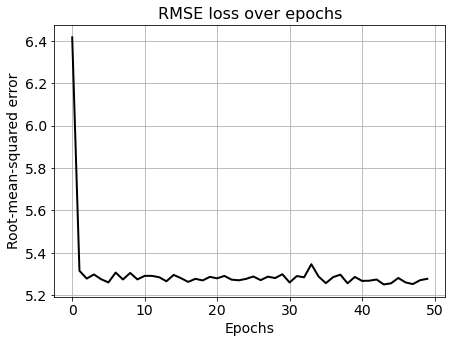

In [186]:

plt.figure(figsize=(7,5))
plt.title("RMSE loss over epochs",fontsize=16)
plt.plot(np.sqrt(model.history.history['loss']),c='k',lw=2)
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Root-mean-squared error",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

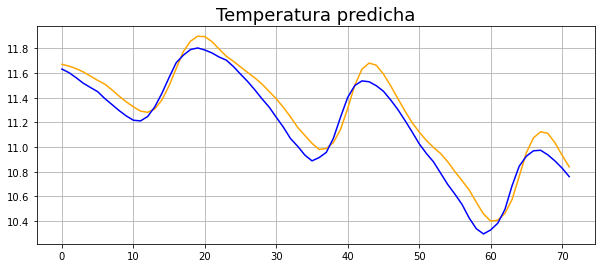

In [174]:
plt.figure(figsize=(10,4))
plt.title("Temperatura predicha",fontsize=18)
plt.plot(testPredict,c='orange')
plt.plot(testY, c='blue')
plt.grid(True)
plt.show()

In [175]:
salinidad_pro

S
Fecha                        
2021-07-01 00:00:00  0.932267
2021-07-01 01:00:00  0.929360
2021-07-01 02:00:00  0.926933
2021-07-01 03:00:00  0.924367
2021-07-01 04:00:00  0.920933
...                       ...
2021-12-31 19:00:00  0.495933
2021-12-31 20:00:00  0.495333
2021-12-31 21:00:00  0.493267
2021-12-31 22:00:00  0.490900
2021-12-31 23:00:00  0.488960

[4292 rows x 1 columns]

In [63]:
salinidad_pro_2 = salinidad_pro.copy()
emb_size = 12

'''
Montamos nuevas features con los lags
'''
for i in range(1, emb_size+1):
    salinidad_pro_2['lag' + str(i)] = salinidad_pro_2['S'].shift(i)
    
salinidad_pro_2.dropna(inplace=True)
salinidad_pro_2.reset_index(drop=True, inplace=True)

values = salinidad_pro_2.values

values

array([[0.90863333, 0.90476667, 0.90508   , ..., 0.92693333, 0.92936   ,
        0.93226667],
       [0.9177    , 0.90863333, 0.90476667, ..., 0.92436667, 0.92693333,
        0.92936   ],
       [0.93006667, 0.9177    , 0.90863333, ..., 0.92093333, 0.92436667,
        0.92693333],
       ...,
       [0.49326667, 0.49533333, 0.49593333, ..., 0.47906667, 0.4778    ,
        0.4795    ],
       [0.4909    , 0.49326667, 0.49533333, ..., 0.48103333, 0.47906667,
        0.4778    ],
       [0.48896   , 0.4909    , 0.49326667, ..., 0.48264   , 0.48103333,
        0.47906667]])

In [411]:

'''
Volvemos a montar xtrain, xtest...
'''
trainX,trainY = values[0:4220-emb_size ,1:],values[0:4220-emb_size ,0],
testX,testY = values[4220-emb_size:4292-emb_size,1:], values[4220-emb_size:4292-emb_size,0]

print("Train data length:", trainX.shape)
print("Train target length:", trainY.shape)
print("Test data length:", testX.shape)
print("Test target length:", testY.shape)

Train data length: (4208, 12)
Train target length: (4208,)
Test data length: (72, 12)
Test target length: (72,)


In [412]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
trainX.shape

(4208, 1, 12)

In [413]:
print("Training data shape:", trainX.shape,', ',trainY.shape)
print("Test data shape:", testX.shape,', ',testY.shape)

Training data shape: (4208, 1, 12) ,  (4208,)
Test data shape: (72, 1, 12) ,  (72,)


In [414]:
modeLSTM_sal = build_simple_rnn()

In [415]:
modeLSTM_sal.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128)               72192     
                                                                 
 dense_4 (Dense)             (None, 32)                4128      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 76,353
Trainable params: 76,353
Non-trainable params: 0
_________________________________________________________________


In [416]:
batch_size=16
num_epochs = 50

In [417]:
modeLSTM_sal.fit(trainX,trainY, 
          epochs=num_epochs, 
          batch_size=batch_size, 
          verbose=0)

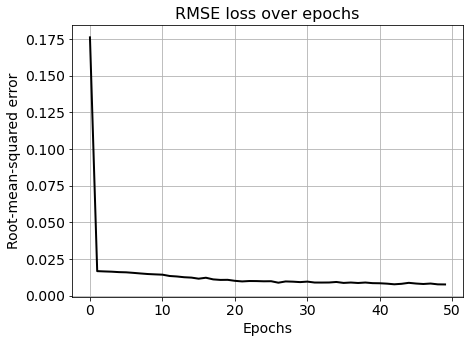

In [419]:
plt.figure(figsize=(7,5))
plt.title("RMSE loss over epochs",fontsize=16)
plt.plot(np.sqrt(modeLSTM_sal.history.history['loss']),c='k',lw=2)
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Root-mean-squared error",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

In [426]:
testPredict_sal = modeLSTM_sal.predict()

3/3 [==============================] - 0s 2ms/step


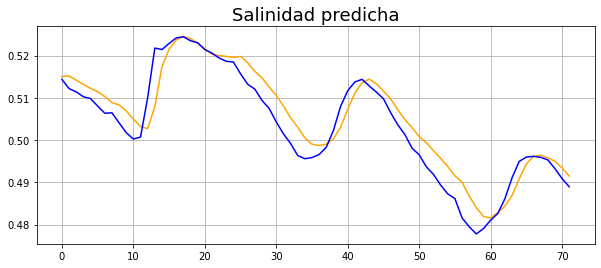

In [428]:
plt.figure(figsize=(10,4))
plt.title("Salinidad predicha",fontsize=18)
plt.plot(testPredict_sal,c='orange')
plt.plot(testY, c='blue')
plt.grid(True)
plt.show()

In [445]:
hum_total = pd.DataFrame(hum_total)

In [446]:
hum_total_2 = hum_total.copy()
emb_size = 12

'''
Montamos nuevas features con los lags
'''
for i in range(1, emb_size+1):
    hum_total_2['lag' + str(i)] = hum_total_2['Htot'].shift(i)
    
hum_total_2.dropna(inplace=True)
hum_total_2.reset_index(drop=True, inplace=True)

values = hum_total_2.values

values

array([[44.62085403, 44.65402756, 44.64176507, ..., 44.47549684,
        44.55851164, 44.75557119],
       [44.5704205 , 44.62085403, 44.65402756, ..., 44.37226415,
        44.47549684, 44.55851164],
       [44.47185764, 44.5704205 , 44.62085403, ..., 44.24270368,
        44.37226415, 44.47549684],
       ...,
       [43.276     , 43.27333333, 43.298     , ..., 43.35733333,
        43.362     , 43.38766667],
       [43.271     , 43.276     , 43.27333333, ..., 43.341     ,
        43.35733333, 43.362     ],
       [43.2628    , 43.271     , 43.276     , ..., 43.3424    ,
        43.341     , 43.35733333]])

In [447]:
hum_total_2

Htot       lag1       lag2       lag3       lag4       lag5  \
0     44.620854  44.654028  44.641765  44.559181  44.408176  44.258816   
1     44.570420  44.620854  44.654028  44.641765  44.559181  44.408176   
2     44.471858  44.570420  44.620854  44.654028  44.641765  44.559181   
3     44.279677  44.471858  44.570420  44.620854  44.654028  44.641765   
4     44.053654  44.279677  44.471858  44.570420  44.620854  44.654028   
...         ...        ...        ...        ...        ...        ...   
4255  43.298000  43.325200  43.334000  43.343000  43.330000  43.335667   
4256  43.273333  43.298000  43.325200  43.334000  43.343000  43.330000   
4257  43.276000  43.273333  43.298000  43.325200  43.334000  43.343000   
4258  43.271000  43.276000  43.273333  43.298000  43.325200  43.334000   
4259  43.262800  43.271000  43.276000  43.273333  43.298000  43.325200   

           lag6       lag7       lag8       lag9      lag10      lag11  \
0     44.217676  44.215789  44.242704  44.372264  44.475497  44.558512   
1     44.258816  44.217676  44.215789  44.242704  44.372264  44.475497   
2     44.408176  44.258816  44.217676  44.215789  44.242704  44.372264   
3     44.559181  44.408176  44.258816  44.217676  44.215789  44.242704   
4     44.641765  44.559181  44.408176  44.258816  44.217676  44.215789   
...         ...        ...        ...        ...        ...        ...   
4255  43.342400  43.341000  43.357333  43.362000  43.387667  43.409200   
4256  43.335667  43.342400  43.341000  43.357333  43.362000  43.387667   
4257  43.330000  43.335667  43.342400  43.341000  43.357333  43.362000   
4258  43.343000  43.330000  43.335667  43.342400  43.341000  43.357333   
4259  43.334000  43.343000  43.330000  43.335667  43.342400  43.341000   

          lag12  
0     44.755571  
1     44.558512  
2     44.475497  
3     44.372264  
4     44.242704  
...         ...  
4255  43.404333  
4256  43.409200  
4257  43.387667  
4258  43.362000  
4259  43.357333  

[4260 rows x 13 columns]

In [448]:

'''
Volvemos a montar xtrain, xtest...
'''
trainX,trainY = values[0:4220-emb_size ,1:],values[0:4220-emb_size ,0],
testX,testY = values[4220-emb_size:4292-emb_size,1:], values[4220-emb_size:4292-emb_size,0]

print("Train data length:", trainX.shape)
print("Train target length:", trainY.shape)
print("Test data length:", testX.shape)
print("Test target length:", testY.shape)

Train data length: (4208, 12)
Train target length: (4208,)
Test data length: (52, 12)
Test target length: (52,)


In [449]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
trainX.shape

(4208, 1, 12)

In [450]:
print("Training data shape:", trainX.shape,', ',trainY.shape)
print("Test data shape:", testX.shape,', ',testY.shape)

Training data shape: (4208, 1, 12) ,  (4208,)
Test data shape: (52, 1, 12) ,  (52,)


In [496]:
modeLSTM_hum = build_simple_rnn()

In [497]:
batch_size=16
num_epochs = 50

In [498]:
modeLSTM_hum.fit(trainX,trainY, 
          epochs=num_epochs, 
          batch_size=batch_size, 
          verbose=0)

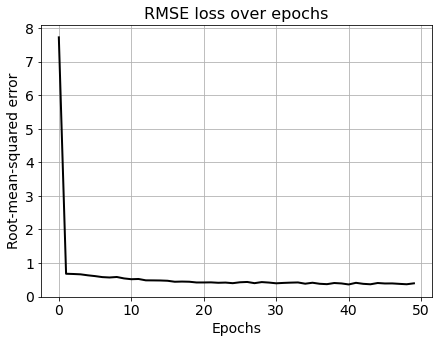

In [491]:
plt.figure(figsize=(7,5))
plt.title("RMSE loss over epochs",fontsize=16)
plt.plot(np.sqrt(modeLSTM_hum.history.history['loss']),c='k',lw=2)
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Root-mean-squared error",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

In [499]:
predict_50_hum = modeLSTM_hum.predict(testX)

2/2 [==============================] - 0s 3ms/step


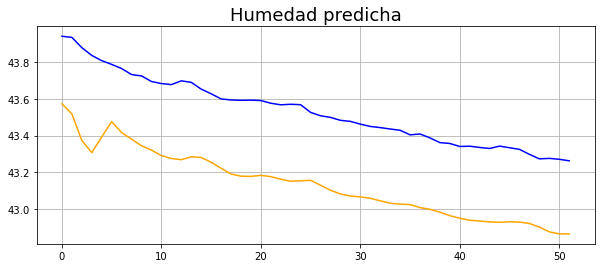

In [500]:
plt.figure(figsize=(10,4))
plt.title("Humedad predicha",fontsize=18)
plt.plot(predict_50_hum,c='orange')
plt.plot(testY, c='blue')
plt.grid(True)
plt.show()

# RECUENTO DE METRICAS

In [274]:
pd.DataFrame({'Temperatura':[MAE_temp, MAE_temp_roll, MAE_temp_rfr], 'Salinidad':[MAE_sal, MAE_sal_roll, MAE_sal_rfr], 'Humedad':[MAE_hum, MAE_hum_roll, MAE_hum_rfr]}, index=['ARIMA_base', 'ARIMA_procesado', 'Random For.'])

Temperatura  Salinidad   Humedad
ARIMA_base          0.449313   0.009718  0.257023
ARIMA_procesado     0.116509   0.001546  0.144319
Random For.         0.062804   0.001840  0.069670

# PREDICCIONES FUTURAS

In [270]:
modelT_final = auto_arima(temperatura_pro,
                    start_p=1,
                    start_q=1,
                    max_d=3,
                    max_p=5,
                    max_q=5,
                    trace=True,
                    stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-13367.565, Time=2.50 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-8530.049, Time=0.71 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-13353.008, Time=0.64 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-11225.220, Time=1.76 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-8528.129, Time=0.32 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-13353.794, Time=6.84 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-13560.050, Time=4.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-12501.887, Time=4.11 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-13910.838, Time=7.65 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-13944.897, Time=7.33 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-13923.688, Time=5.99 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-13939.481, Time=8.89 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-13571.620, Time=10.37 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-13951.841, Time=7.54 sec
 ARIMA

In [271]:
modelS_final = auto_arima(salinidad_pro,
                    start_p=1,
                    start_q=1,
                    max_d=3,
                    max_p=5,
                    max_q=5,
                    trace=True,
                    stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-35277.353, Time=1.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-33035.895, Time=1.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-35160.579, Time=0.98 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-34961.168, Time=2.50 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-33036.169, Time=0.41 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-35274.682, Time=2.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-35267.412, Time=2.30 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-35163.742, Time=3.86 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-35273.400, Time=2.50 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-35283.406, Time=2.48 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-35453.674, Time=5.66 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-35262.019, Time=1.81 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-35456.588, Time=3.67 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-35420.792, Time=1.28 sec
 ARIM

In [261]:
modelH_final = auto_arima(humedad_pro,
                    start_p=1,
                    start_q=1,
                    max_d=3,
                    max_p=5,
                    max_q=5,
                    trace=True,
                    stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-36976.492, Time=1.55 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-34675.445, Time=0.76 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-36585.255, Time=1.38 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-36837.579, Time=2.37 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=-37048.957, Time=3.40 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=-37020.756, Time=1.83 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=-36986.402, Time=2.78 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=-37093.723, Time=3.44 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=-37000.389, Time=7.50 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=-37013.181, Time=6.86 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=-37140.742, Time=3.42 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=-36950.787, Time=7.39 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=-37240.643, Time=4.14 sec
 ARIMA(4,2,3)(0,0,0)[0]             : AIC=-37276.803, Time=4.12 sec
 ARIM

In [272]:
modelT_final.fit(temperatura_pro)

ARIMA(order=(2, 1, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [273]:
modelS_final.fit(salinidad_pro)

ARIMA(order=(4, 1, 4), scoring_args={}, suppress_warnings=True)

In [264]:
modelH_final.fit(humedad_pro)

ARIMA(order=(4, 2, 5), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [274]:
pred_final_temp = modelT_final.predict(72)

In [275]:
pred_final_sal = modelS_final.predict(72)

In [267]:
pred_final_hum = modelH_final.predict(72)

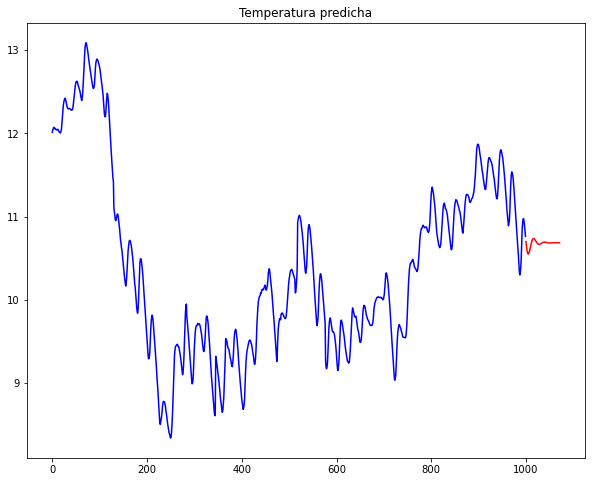

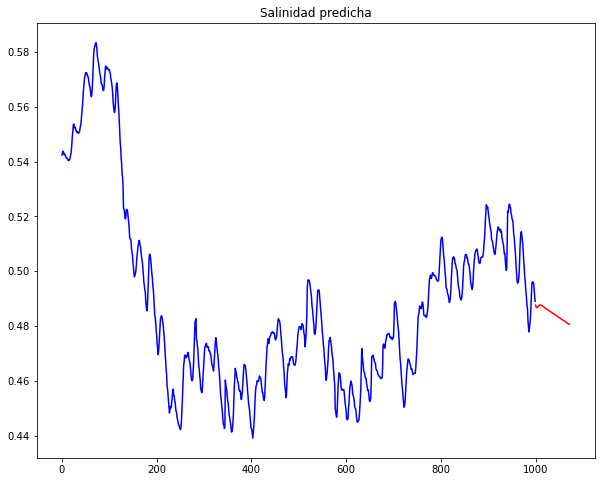

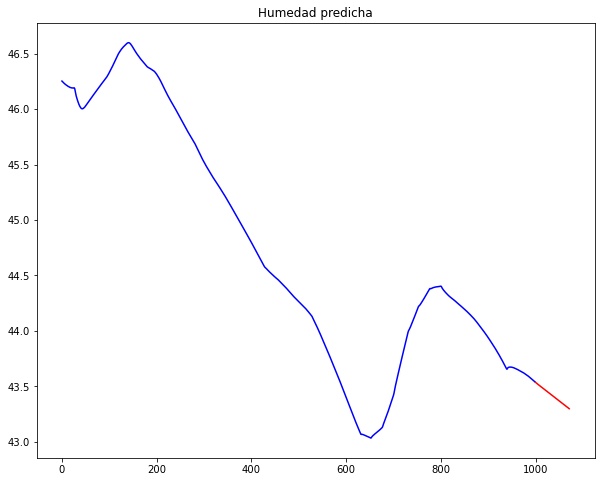

In [276]:
def future_graph (train,predictions,title):

    serie = pd.Series(predictions)
    empty_serie = pd.Series(np.nan, index=range(1000))
    data = pd.concat([empty_serie, serie])

    plt.figure(figsize=(10,8))
    plt.plot(train.iloc[-1000:].values, color='blue')
    plt.plot(data.values, color='red')
    plt.title(title)

future_graph(temperatura_pro, pred_final_temp, 'Temperatura predicha')
future_graph(salinidad_pro, pred_final_sal, 'Salinidad predicha')
future_graph(hum_roll, pred_final_hum, 'Humedad predicha')

In [268]:
Final_Predictions = pd.DataFrame({'T_pred':pred_final_temp, 'S_pred':pred_final_sal, 'H_pred':pred_final_hum})

Final_Predictions

T_pred    S_pred     H_pred
0   11.287983  0.505861  43.535256
1   11.276316  0.505516  43.531598
2   11.264716  0.505180  43.528074
3   11.253377  0.504861  43.524606
4   11.242433  0.504559  43.521183
..        ...       ...        ...
67  10.674363  0.487061  43.311445
68  10.665326  0.486766  43.308119
69  10.656290  0.486470  43.304793
70  10.647253  0.486173  43.301467
71  10.638217  0.485876  43.298141

[72 rows x 3 columns]

# Como identificar cuando hay que regar?

Lo primero es identificar una lluvia en los datos de humedad y proceder a identificar el cambio de pendiente del pico asociado a la lluvia en cuestión. En este punto de cambio de pendiente será donde marquemos nuestra llamada **Profundidad de Campo** que es el valor máximo de humedad que tolera el agua. A partir de este valor calculamos el **umbral de riego** que se define generalmente como la un 80% de la profundidad de campo, aunque este valor es variable según las necesidades del cultivo.

In [212]:
import plotly.express as px

fig = px.line(humedad, x=humedad.index, y=humedad['H40'], title='Humedad a 40 cm')
fig.show()


fig = px.line(humedad, x=humedad.index, y=humedad['H60'], title='Humedad a 60 cm')
fig.show()

In [254]:
profundidad_campo = 45.5

umbral_riego = 45.5 * 0.8

umbral_riego

36.4

En base a las predicciones que hemos hecho podemos "etiquetalas" con el fin de indicar a una unidad que accione o no el riego por goteo. Las etiquetas serian las siguientes:

- Si la humedad desciende por debajo del umbral de riego, 36.4, el riego debe accionarse, si no no. A no ser que:
- la temperatura sea menor de 12 o mayor de 30 grados
- Si por otro lado la salinidad es mayor a 3.5, puede haber efectos fitotoxicos y se debería dar un riego especial

Así pues las etiquetas serían:
- Riego --> 1
- No Riego --> 0
- Riego especial --> 2

In [255]:
def etiquetado(predictions) :

    if ((predictions.H_pred < umbral_riego and (predictions.T_pred < 12 or predictions.T_pred > 30)) and predictions.S_pred < 3.5):
        return 0
    elif predictions.H_pred < umbral_riego and (predictions.T_pred > 12 or predictions.T_pred < 30) and predictions.S_pred < 3.5:
        return 1
    elif predictions.H_pred > umbral_riego and (predictions.T_pred < 12 or predictions.T_pred > 30) and predictions.S_pred < 3.5:
        return 0
    elif predictions.H_pred > umbral_riego and (predictions.T_pred > 12 or predictions.T_pred < 30) and predictions.S_pred < 3.5:
        return 0
    else:
        return 2

In [265]:
Final_Predictions['Riego'] = Final_Predictions.apply(etiquetado, axis=1)

new_row = pd.DataFrame({'T_pred':12.0, 'S_pred': 5, 'H_pred':44}, index=[0])
new_row2 = pd.DataFrame({'T_pred':20.0, 'S_pred': 2, 'H_pred':35}, index=[0])


Final_predictions2 = pd.concat([Final_Predictions, new_row, new_row2]).reset_index(drop=True)

Final_predictions2.apply(etiquetado, axis=1)

0     0
1     0
2     0
3     0
4     0
     ..
69    0
70    0
71    0
72    2
73    1
Length: 74, dtype: int64